# 0 - Load modules

In [2]:
import sys
import xarray as xr
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import glob
from netCDF4 import Dataset
import cartopy.crs as ccrs
import json
import os
import matplotlib.gridspec as gridspec
import matplotlib.image as mpimg

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline



/scratch/cnt0024/hmg2840/albert7a/anaconda3/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


In [18]:
def plot_mean_profiles(reg,config,case):
    namezone='NATL60-CJM165_'+reg+'_y2012-2013'
    jsonfile='/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_'+reg+'_y2012-2013/NATL60-CJM165_'+reg+'_y2012-2013.json'
    dirn='/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_'+reg+'_y2012-2013/'+config+'-'+case+'/'    
    
    #averaging the data in boxes

    vert_standart=[0,2,4,6,8,10,12,14,16,18,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100,110,120,130,140,150,160,170,180,190,200,220,240,260,280,300,320,340,360,380,400,420,440,460,480,500,520,540,560,580,600,620,640,660,680,700,720,740,760,780,800,820,840,860,880,900,920,940,960,980,1000,1050,1100,1150,1200,1250,1300,1350,1400,1450,1500,1550,1600,1650,1700,1750,1800,1850,1900,1950,2000]

    def get_netcdf_profiles(netcdf_name):

        dsprof=xr.open_dataset(netcdf_name)
        depth=dsprof['depth_en4']
        temp_en4=dsprof['temp_profileEN4']
        salt_en4=dsprof['salt_profileEN4']
        mean_temp_model=dsprof['mean_temp_model']
        mean_salt_model=dsprof['mean_salt_model']
        percent10_temp_model=dsprof['percent10_temp_model']
        percent10_salt_model=dsprof['percent10_salt_model']
        percent90_temp_model=dsprof['percent90_temp_model']
        percent90_salt_model=dsprof['percent90_salt_model']

        return depth,temp_en4,salt_en4,mean_temp_model,mean_salt_model,percent10_temp_model,percent10_salt_model,percent90_temp_model,percent90_salt_model


    sourcefile=open(jsonfile,'rU')
    infos=json.load(sourcefile)
    nb_profilesEN4=len(infos)

    print(str(nb_profilesEN4)+' profils a la base ...')
    nb=0


    all_temp_mean_model=np.zeros((nb_profilesEN4,len(vert_standart)))
    all_salt_mean_model=np.zeros((nb_profilesEN4,len(vert_standart)))
    all_temp_en4=np.zeros((nb_profilesEN4,len(vert_standart)))
    all_salt_en4=np.zeros((nb_profilesEN4,len(vert_standart)))
    all_temp_percent10_model=np.zeros((nb_profilesEN4,len(vert_standart)))
    all_salt_percent10_model=np.zeros((nb_profilesEN4,len(vert_standart)))
    all_temp_percent90_model=np.zeros((nb_profilesEN4,len(vert_standart)))
    all_salt_percent90_model=np.zeros((nb_profilesEN4,len(vert_standart)))

    for prof in np.arange(nb_profilesEN4):
        list_profiles = infos.keys()
        reference = str(list(list_profiles)[prof])
        reference_profile=reference[-16:-1]
        outname=dirn+"/profiles_EN4-"+reference_profile+"_"+config+"-"+case+"_TS_vert-stand.nc"

        if os.path.exists(outname):
            depth,temp_en4,salt_en4,mean_temp_model,mean_salt_model,percent10_temp_model,percent10_salt_model,percent90_temp_model,percent90_salt_model = get_netcdf_profiles(outname)
            ien4=np.where(np.isnan(temp_en4)==True)
            if len(ien4[:][0]) >0:
                d=depth[np.min(ien4[:][0])].values
            else:
                d=2000
            nb=nb+1
            all_temp_mean_model[prof,:]=mean_temp_model[:]
            all_salt_mean_model[prof,:]=mean_salt_model[:]
            all_temp_en4[prof,:]=temp_en4[:]
            all_salt_en4[prof,:]=salt_en4[:]
            all_temp_percent10_model[prof,:]=percent10_temp_model[:]
            all_salt_percent10_model[prof,:]=percent10_salt_model[:]
            all_temp_percent90_model[prof,:]=percent90_temp_model[:]
            all_salt_percent90_model[prof,:]=percent90_salt_model[:]

    print(str(nb)+' profils finalement ..')

    all_temp_mean_model[all_temp_mean_model==0.]='nan'
    all_salt_mean_model[all_salt_mean_model==0.]='nan'
    all_temp_en4[all_temp_en4==0.]='nan'
    all_salt_en4[all_salt_en4==0.]='nan'
    all_temp_percent10_model[all_temp_percent10_model==0.]='nan'
    all_salt_percent10_model[all_salt_percent10_model==0.]='nan'
    all_temp_percent90_model[all_temp_percent90_model==0.]='nan'
    all_salt_percent90_model[all_salt_percent90_model==0.]='nan'

    all_salt_en4[all_salt_en4<30.]='nan'


    # Mean Bias are computed
    mean_temp_en4=np.nanmean(all_temp_en4,0)
    mean_temp_mod=np.nanmean(all_temp_mean_model,0)
    mean_salt_en4=np.nanmean(all_salt_en4,0)
    mean_salt_mod=np.nanmean(all_salt_mean_model,0)
    temp_percent10=np.nanmean(all_temp_percent10_model,0)
    salt_percent10=np.nanmean(all_salt_percent10_model,0)
    temp_percent90=np.nanmean(all_temp_percent90_model,0)
    salt_percent90=np.nanmean(all_salt_percent90_model,0)

    fig, axs = plt.subplots(1,2, figsize=(10, 6))
    axs = axs.ravel()
    title = 'Temperature and Salinity Profiles for run '+config+'-'+case
    plt.suptitle(title,size = 25,y=1.05)
    axs[0].plot(mean_temp_mod,vert_standart,'b.-', label='temp model')
    axs[0].plot(mean_temp_en4,vert_standart,'k.-', label='temp en4')
    axs[0].set_ylabel('Depth [m]', size=14)
    axs[0].set_ylim(2000, 0)
    axs[0].grid(True, which='both')
    axs[0].xaxis.tick_top()
    axs[0].xaxis.set_label_position('top') 
    axs[0].plot(temp_percent10,vert_standart,'b-', label='percent10')
    axs[0].plot(temp_percent90,vert_standart,'b-', label='percent90')
    axs[0].fill_betweenx(vert_standart, temp_percent10, x2=temp_percent90, alpha=0.2, facecolor='b')

    axs[1].plot(mean_salt_mod,vert_standart,'b.-', label='salt model')
    axs[1].plot(mean_salt_en4,vert_standart,'k.-', label='salt en4')
    axs[1].set_ylabel('Depth [m]', size=14)
    axs[1].set_ylim(2000, 0)
    axs[1].grid(True, which='both')
    axs[1].xaxis.tick_top()
    axs[1].xaxis.set_label_position('top') 
    axs[1].plot(salt_percent10,vert_standart,'b-', label='percent10')
    axs[1].plot(salt_percent90,vert_standart,'b-', label='percent90')
    axs[1].fill_betweenx(vert_standart, salt_percent10, x2=salt_percent90, alpha=0.2, facecolor='b')


    fig.tight_layout()
    plt.savefig('Plots/Mean-Profiles-'+config+'-'+case+'.png')


56203 profils a la base ...
4211 profils finalement ..


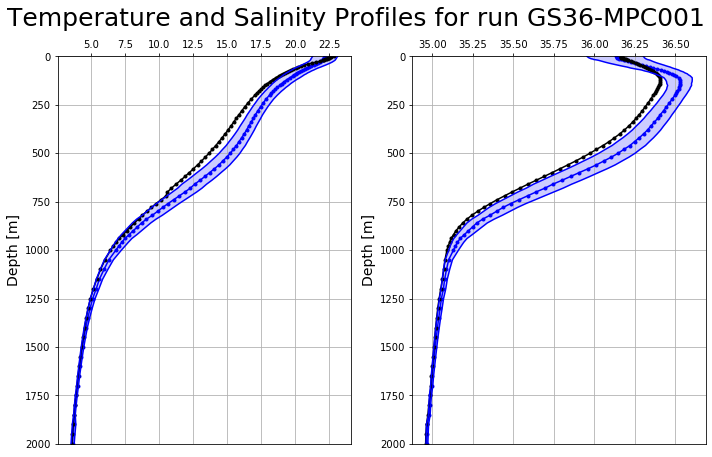

In [19]:
plot_mean_profiles('GS','GS36','MPC001')

56203 profils a la base ...
0 profils finalement ..


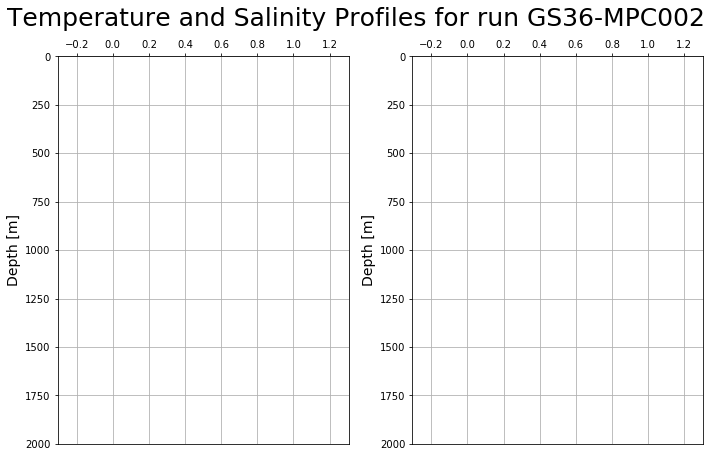

In [20]:
plot_mean_profiles('GS','GS36','MPC002')

In [11]:
config='GS36'
case='MPC001'
namezone='NATL60-CJM165_GS_y2012-2013'
jsonfile='/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/NATL60-CJM165_GS_y2012-2013.json'
dirn='/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/'+config+'-'+case+'/'

In [12]:
#averaging the data in boxes

vert_standart=[0,2,4,6,8,10,12,14,16,18,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100,110,120,130,140,150,160,170,180,190,200,220,240,260,280,300,320,340,360,380,400,420,440,460,480,500,520,540,560,580,600,620,640,660,680,700,720,740,760,780,800,820,840,860,880,900,920,940,960,980,1000,1050,1100,1150,1200,1250,1300,1350,1400,1450,1500,1550,1600,1650,1700,1750,1800,1850,1900,1950,2000]

def get_netcdf_profiles(netcdf_name):
    
    dsprof=xr.open_dataset(netcdf_name)
    depth=dsprof['depth_en4']
    temp_en4=dsprof['temp_profileEN4']
    salt_en4=dsprof['salt_profileEN4']
    mean_temp_model=dsprof['mean_temp_model']
    mean_salt_model=dsprof['mean_salt_model']
    percent10_temp_model=dsprof['percent10_temp_model']
    percent10_salt_model=dsprof['percent10_salt_model']
    percent90_temp_model=dsprof['percent90_temp_model']
    percent90_salt_model=dsprof['percent90_salt_model']

    return depth,temp_en4,salt_en4,mean_temp_model,mean_salt_model,percent10_temp_model,percent10_salt_model,percent90_temp_model,percent90_salt_model


sourcefile=open(jsonfile,'rU')
infos=json.load(sourcefile)
nb_profilesEN4=len(infos)

print(str(nb_profilesEN4)+' profils a la base ...')
nb=0
    

all_temp_mean_model=np.zeros((nb_profilesEN4,len(vert_standart)))
all_salt_mean_model=np.zeros((nb_profilesEN4,len(vert_standart)))
all_temp_en4=np.zeros((nb_profilesEN4,len(vert_standart)))
all_salt_en4=np.zeros((nb_profilesEN4,len(vert_standart)))
all_temp_percent10_model=np.zeros((nb_profilesEN4,len(vert_standart)))
all_salt_percent10_model=np.zeros((nb_profilesEN4,len(vert_standart)))
all_temp_percent90_model=np.zeros((nb_profilesEN4,len(vert_standart)))
all_salt_percent90_model=np.zeros((nb_profilesEN4,len(vert_standart)))

for prof in np.arange(nb_profilesEN4):
    list_profiles = infos.keys()
    reference = str(list(list_profiles)[prof])
    reference_profile=reference[-16:-1]
    print("dealing with profile "+reference_profile)
    outname=dirn+"/profiles_EN4-"+reference_profile+"_"+config+"-"+case+"_TS_vert-stand.nc"

    if os.path.exists(outname):
        print(outname+" exists")
        depth,temp_en4,salt_en4,mean_temp_model,mean_salt_model,percent10_temp_model,percent10_salt_model,percent90_temp_model,percent90_salt_model = get_netcdf_profiles(outname)
        ien4=np.where(np.isnan(temp_en4)==True)
        if len(ien4[:][0]) >0:
            d=depth[np.min(ien4[:][0])].values
        else:
            d=2000
        nb=nb+1
        all_temp_mean_model[prof,:]=mean_temp_model[:]
        all_salt_mean_model[prof,:]=mean_salt_model[:]
        all_temp_en4[prof,:]=temp_en4[:]
        all_salt_en4[prof,:]=salt_en4[:]
        all_temp_percent10_model[prof,:]=percent10_temp_model[:]
        all_salt_percent10_model[prof,:]=percent10_salt_model[:]
        all_temp_percent90_model[prof,:]=percent90_temp_model[:]
        all_salt_percent90_model[prof,:]=percent90_salt_model[:]

print(str(nb)+' profils finalement ..')

all_temp_mean_model[all_temp_mean_model==0.]='nan'
all_salt_mean_model[all_salt_mean_model==0.]='nan'
all_temp_en4[all_temp_en4==0.]='nan'
all_salt_en4[all_salt_en4==0.]='nan'
all_temp_percent10_model[all_temp_percent10_model==0.]='nan'
all_salt_percent10_model[all_salt_percent10_model==0.]='nan'
all_temp_percent90_model[all_temp_percent90_model==0.]='nan'
all_salt_percent90_model[all_salt_percent90_model==0.]='nan'
    
all_salt_en4[all_salt_en4<30.]='nan'
    

# Mean Bias are computed
mean_temp_en4=np.nanmean(all_temp_en4,0)
mean_temp_mod=np.nanmean(all_temp_mean_model,0)
mean_salt_en4=np.nanmean(all_salt_en4,0)
mean_salt_mod=np.nanmean(all_salt_mean_model,0)
temp_percent10=np.nanmean(all_temp_percent10_model,0)
salt_percent10=np.nanmean(all_salt_percent10_model,0)
temp_percent90=np.nanmean(all_temp_percent90_model,0)
salt_percent90=np.nanmean(all_salt_percent90_model,0)


56203 profils a la base ...
dealing with profile A20121001-03173
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20121001-03173_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20121001-03175
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20121001-03175_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20121001-03182
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20121001-03182_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20121001-03196
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20121001-03196_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20121001-03200
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20121001-03200_GS36-MPC001_TS_vert-stand.nc

dealing with profile A20121001-89448
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20121001-89448_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20121001-89451
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20121001-89451_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20121001-89452
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20121001-89452_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20121001-89454
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20121001-89454_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20121001-89457
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20121001-89457_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile

dealing with profile A20121003-03444
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20121003-03444_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20121003-03453
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20121003-03453_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20121003-03455
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20121003-03455_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20121003-03458
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20121003-03458_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20121003-03463
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20121003-03463_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile

/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20121005-03678_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20121005-03679
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20121005-03679_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20121005-03685
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20121005-03685_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20121005-03688
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20121005-03688_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20121005-03694
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20121005-03694_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20121005-03703
/scratch/cnt0024/hmg

dealing with profile A20121006-69513
dealing with profile A20121006-69516
dealing with profile A20121006-69518
dealing with profile A20121006-69522
dealing with profile A20121006-69523
dealing with profile A20121006-69525
dealing with profile A20121006-69529
dealing with profile A20121006-69530
dealing with profile A20121006-69533
dealing with profile A20121006-69534
dealing with profile A20121006-69535
dealing with profile A20121006-69538
dealing with profile A20121006-69541
dealing with profile A20121006-89589
dealing with profile A20121006-89594
dealing with profile A20121006-89596
dealing with profile A20121006-89600
dealing with profile A20121006-89603
dealing with profile A20121006-89606
dealing with profile A20121006-89607
dealing with profile A20121006-89610
dealing with profile A20121006-89615
dealing with profile A20121006-89618
dealing with profile A20121006-89621
dealing with profile A20121006-89625
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012

dealing with profile A20121007-89661
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20121007-89661_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20121007-89662
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20121007-89662_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20121007-89663
dealing with profile A20121007-89664
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20121007-89664_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20121007-89666
dealing with profile A20121007-89670
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20121007-89670_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20121007-89671
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN

dealing with profile A20121009-04126
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20121009-04126_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20121009-04130
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20121009-04130_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20121009-04140
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20121009-04140_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20121009-04147
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20121009-04147_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20121009-04162
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20121009-04162_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile

dealing with profile A20121010-69732
dealing with profile A20121010-69736
dealing with profile A20121010-69740
dealing with profile A20121010-69743
dealing with profile A20121010-69745
dealing with profile A20121010-69747
dealing with profile A20121010-69754
dealing with profile A20121010-69762
dealing with profile A20121010-69771
dealing with profile A20121010-69777
dealing with profile A20121010-69790
dealing with profile A20121010-69801
dealing with profile A20121010-89712
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20121010-89712_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20121010-89721
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20121010-89721_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20121010-89725
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20121010-89725_GS36

dealing with profile A20121012-04444
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20121012-04444_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20121012-04445
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20121012-04445_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20121012-04449
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20121012-04449_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20121012-04455
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20121012-04455_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20121012-04476
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20121012-04476_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile

dealing with profile A20121013-43833
dealing with profile A20121013-43857
dealing with profile A20121013-43858
dealing with profile A20121013-43859
dealing with profile A20121013-43860
dealing with profile A20121013-43861
dealing with profile A20121013-43862
dealing with profile A20121013-43863
dealing with profile A20121013-43864
dealing with profile A20121013-43865
dealing with profile A20121013-43866
dealing with profile A20121013-43867
dealing with profile A20121013-43868
dealing with profile A20121013-43891
dealing with profile A20121013-43892
dealing with profile A20121013-43893
dealing with profile A20121013-43894
dealing with profile A20121013-43895
dealing with profile A20121013-43896
dealing with profile A20121013-43915
dealing with profile A20121013-43916
dealing with profile A20121013-43917
dealing with profile A20121013-43918
dealing with profile A20121013-43919
dealing with profile A20121013-43920
dealing with profile A20121013-43921
dealing with profile A20121013-43922
d

dealing with profile A20121015-04781
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20121015-04781_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20121015-04798
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20121015-04798_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20121015-04802
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20121015-04802_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20121015-43737
dealing with profile A20121015-43738
dealing with profile A20121015-43739
dealing with profile A20121015-43740
dealing with profile A20121015-43741
dealing with profile A20121015-43742
dealing with profile A20121015-43773
dealing with profile A20121015-43774
dealing with profile A20121015-43775
dealing with profile A20121015-43776
dealing with profile A20121015-43777
deali

dealing with profile A20121017-04950
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20121017-04950_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20121017-04955
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20121017-04955_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20121017-04960
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20121017-04960_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20121017-04977
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20121017-04977_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20121017-04981
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20121017-04981_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile

dealing with profile A20121018-45202
dealing with profile A20121018-45203
dealing with profile A20121018-45204
dealing with profile A20121018-45205
dealing with profile A20121018-45206
dealing with profile A20121018-45207
dealing with profile A20121018-45208
dealing with profile A20121018-45209
dealing with profile A20121018-45210
dealing with profile A20121018-45211
dealing with profile A20121018-45212
dealing with profile A20121018-45213
dealing with profile A20121018-45226
dealing with profile A20121018-45227
dealing with profile A20121018-45228
dealing with profile A20121018-45229
dealing with profile A20121018-45230
dealing with profile A20121018-45231
dealing with profile A20121018-45232
dealing with profile A20121018-45233
dealing with profile A20121018-45234
dealing with profile A20121018-45235
dealing with profile A20121018-45236
dealing with profile A20121018-45237
dealing with profile A20121018-45250
dealing with profile A20121018-45251
dealing with profile A20121018-45252
d

dealing with profile A20121019-70426
dealing with profile A20121019-89968
dealing with profile A20121019-89971
dealing with profile A20121019-89980
dealing with profile A20121019-89983
dealing with profile A20121019-89990
dealing with profile A20121019-89994
dealing with profile A20121019-89996
dealing with profile A20121020-05210
dealing with profile A20121020-05212
dealing with profile A20121020-05214
dealing with profile A20121020-05242
dealing with profile A20121020-05256
dealing with profile A20121020-05260
dealing with profile A20121020-05272
dealing with profile A20121020-05293
dealing with profile A20121020-45912
dealing with profile A20121020-45913
dealing with profile A20121020-45914
dealing with profile A20121020-45915
dealing with profile A20121020-45916
dealing with profile A20121020-45917
dealing with profile A20121020-45918
dealing with profile A20121020-45919
dealing with profile A20121020-45920
dealing with profile A20121020-45921
dealing with profile A20121020-45922
d

dealing with profile A20121022-05445
dealing with profile A20121022-05462
dealing with profile A20121022-05463
dealing with profile A20121022-05473
dealing with profile A20121022-05475
dealing with profile A20121022-05483
dealing with profile A20121022-05484
dealing with profile A20121022-05485
dealing with profile A20121022-05497
dealing with profile A20121022-45936
dealing with profile A20121022-45937
dealing with profile A20121022-45938
dealing with profile A20121022-45939
dealing with profile A20121022-45940
dealing with profile A20121022-45941
dealing with profile A20121022-45971
dealing with profile A20121022-45972
dealing with profile A20121022-45973
dealing with profile A20121022-45974
dealing with profile A20121022-45975
dealing with profile A20121022-45976
dealing with profile A20121022-46007
dealing with profile A20121022-46008
dealing with profile A20121022-46009
dealing with profile A20121022-46010
dealing with profile A20121022-46011
dealing with profile A20121022-46012
d

dealing with profile A20121023-90128
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20121023-90128_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20121023-90138
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20121023-90138_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20121023-90160
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20121023-90160_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20121023-90180
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20121023-90180_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20121024-05637
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20121024-05637_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile

dealing with profile A20121026-05842
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20121026-05842_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20121026-05844
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20121026-05844_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20121026-05856
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20121026-05856_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20121026-05865
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20121026-05865_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20121026-05886
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20121026-05886_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile

dealing with profile A20121028-06048
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20121028-06048_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20121028-06060
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20121028-06060_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20121028-06061
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20121028-06061_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20121028-06069
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20121028-06069_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20121028-06093
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20121028-06093_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile

dealing with profile A20121031-39060
dealing with profile A20121031-39061
dealing with profile A20121031-39062
dealing with profile A20121031-39063
dealing with profile A20121031-39064
dealing with profile A20121031-39065
dealing with profile A20121031-39079
dealing with profile A20121031-39080
dealing with profile A20121031-39081
dealing with profile A20121031-39082
dealing with profile A20121031-39083
dealing with profile A20121031-39540
dealing with profile A20121031-39541
dealing with profile A20121031-39542
dealing with profile A20121031-39543
dealing with profile A20121031-39544
dealing with profile A20121031-39545
dealing with profile A20121031-39546
dealing with profile A20121031-39547
dealing with profile A20121031-39548
dealing with profile A20121031-39549
dealing with profile A20121031-39550
dealing with profile A20121031-39551
dealing with profile A20121031-39552
dealing with profile A20121031-39553
dealing with profile A20121031-39554
dealing with profile A20121031-39555
d

dealing with profile A20121102-03510
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20121102-03510_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20121102-03511
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20121102-03511_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20121102-03525
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20121102-03525_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20121102-03531
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20121102-03531_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20121102-03536
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20121102-03536_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile

dealing with profile A20121103-85352
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20121103-85352_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20121103-85355
dealing with profile A20121103-85356
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20121103-85356_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20121103-85359
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20121103-85359_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20121103-85362
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20121103-85362_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20121103-85364
dealing with profile A20121103-85365
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN

dealing with profile A20121105-39251
dealing with profile A20121105-39252
dealing with profile A20121105-39253
dealing with profile A20121105-39254
dealing with profile A20121105-39255
dealing with profile A20121105-39256
dealing with profile A20121105-39257
dealing with profile A20121105-39258
dealing with profile A20121105-39259
dealing with profile A20121105-39294
dealing with profile A20121105-39295
dealing with profile A20121105-39296
dealing with profile A20121105-39297
dealing with profile A20121105-39298
dealing with profile A20121105-39299
dealing with profile A20121105-39300
dealing with profile A20121105-39301
dealing with profile A20121105-39302
dealing with profile A20121105-39303
dealing with profile A20121105-39304
dealing with profile A20121105-39305
dealing with profile A20121105-39342
dealing with profile A20121105-39343
dealing with profile A20121105-39344
dealing with profile A20121105-39345
dealing with profile A20121105-39346
dealing with profile A20121105-39347
d

dealing with profile A20121105-85542
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20121105-85542_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20121105-85543
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20121105-85543_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20121105-85546
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20121105-85546_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20121105-85548
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20121105-85548_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20121105-85549
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20121105-85549_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile

dealing with profile A20121107-04009
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20121107-04009_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20121107-04020
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20121107-04020_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20121107-04021
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20121107-04021_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20121107-04023
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20121107-04023_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20121107-04028
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20121107-04028_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile

dealing with profile A20121109-04225
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20121109-04225_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20121109-04226
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20121109-04226_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20121109-04268
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20121109-04268_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20121109-04272
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20121109-04272_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20121109-04294
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20121109-04294_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile

dealing with profile A20121110-85620
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20121110-85620_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20121110-85626
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20121110-85626_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20121110-85628
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20121110-85628_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20121110-85634
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20121110-85634_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20121111-04435
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20121111-04435_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile

dealing with profile A20121112-04594
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20121112-04594_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20121112-04596
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20121112-04596_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20121112-04602
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20121112-04602_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20121112-04615
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20121112-04615_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20121112-04624
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20121112-04624_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile

dealing with profile A20121113-85722
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20121113-85722_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20121113-85723
dealing with profile A20121113-85725
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20121113-85725_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20121113-85730
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20121113-85730_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20121113-85734
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20121113-85734_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20121113-85739
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20121113-85739_GS36-MPC001_TS_vert

dealing with profile A20121114-85766
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20121114-85766_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20121114-85771
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20121114-85771_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20121114-85778
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20121114-85778_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20121114-85780
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20121114-85780_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20121114-85787
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20121114-85787_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile

dealing with profile A20121116-42853
dealing with profile A20121116-42875
dealing with profile A20121116-42876
dealing with profile A20121116-42877
dealing with profile A20121116-42878
dealing with profile A20121116-42879
dealing with profile A20121116-42905
dealing with profile A20121116-42906
dealing with profile A20121116-42907
dealing with profile A20121116-42908
dealing with profile A20121116-42909
dealing with profile A20121116-42933
dealing with profile A20121116-42934
dealing with profile A20121116-42935
dealing with profile A20121116-42936
dealing with profile A20121116-42937
dealing with profile A20121116-42938
dealing with profile A20121116-42960
dealing with profile A20121116-42961
dealing with profile A20121116-42962
dealing with profile A20121116-42963
dealing with profile A20121116-42964
dealing with profile A20121116-42990
dealing with profile A20121116-42991
dealing with profile A20121116-42992
dealing with profile A20121116-42993
dealing with profile A20121116-42994
d

dealing with profile A20121118-05190
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20121118-05190_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20121118-05200
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20121118-05200_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20121118-05202
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20121118-05202_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20121118-05217
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20121118-05217_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20121118-05221
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20121118-05221_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile

dealing with profile A20121119-85953
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20121119-85953_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20121119-85957
dealing with profile A20121119-85960
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20121119-85960_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20121119-85964
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20121119-85964_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20121119-85971
dealing with profile A20121119-85973
dealing with profile A20121119-85976
dealing with profile A20121119-85977
dealing with profile A20121119-85979
dealing with profile A20121119-85987
dealing with profile A20121119-85993
dealing with profile A20121120-05388
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-201

dealing with profile A20121122-05605
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20121122-05605_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20121122-05612
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20121122-05612_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20121122-05617
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20121122-05617_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20121122-05625
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20121122-05625_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20121122-05629
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20121122-05629_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile

dealing with profile A20121124-44459
dealing with profile A20121124-44460
dealing with profile A20121124-44461
dealing with profile A20121124-44462
dealing with profile A20121124-44463
dealing with profile A20121124-44464
dealing with profile A20121124-44465
dealing with profile A20121124-44466
dealing with profile A20121124-44467
dealing with profile A20121124-44468
dealing with profile A20121124-44493
dealing with profile A20121124-44494
dealing with profile A20121124-44495
dealing with profile A20121124-44496
dealing with profile A20121124-44497
dealing with profile A20121124-44498
dealing with profile A20121124-44499
dealing with profile A20121124-44500
dealing with profile A20121124-44501
dealing with profile A20121124-44502
dealing with profile A20121124-44503
dealing with profile A20121124-44504
dealing with profile A20121124-44528
dealing with profile A20121124-44529
dealing with profile A20121124-44530
dealing with profile A20121124-44531
dealing with profile A20121124-44532
d

dealing with profile A20121126-44445
dealing with profile A20121126-44446
dealing with profile A20121126-44447
dealing with profile A20121126-44448
dealing with profile A20121126-44449
dealing with profile A20121126-44450
dealing with profile A20121126-44451
dealing with profile A20121126-44481
dealing with profile A20121126-44482
dealing with profile A20121126-44483
dealing with profile A20121126-44484
dealing with profile A20121126-44485
dealing with profile A20121126-44486
dealing with profile A20121126-44487
dealing with profile A20121126-44517
dealing with profile A20121126-44518
dealing with profile A20121126-44519
dealing with profile A20121126-44520
dealing with profile A20121126-44521
dealing with profile A20121126-44522
dealing with profile A20121126-44523
dealing with profile A20121126-44549
dealing with profile A20121126-44550
dealing with profile A20121126-44551
dealing with profile A20121126-44552
dealing with profile A20121126-44553
dealing with profile A20121126-44554
d

dealing with profile A20121128-06282
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20121128-06282_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20121128-06293
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20121128-06293_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20121128-06323
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20121128-06323_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20121128-45066
dealing with profile A20121128-45067
dealing with profile A20121128-45068
dealing with profile A20121128-45069
dealing with profile A20121128-45087
dealing with profile A20121128-45088
dealing with profile A20121128-45089
dealing with profile A20121128-45090
dealing with profile A20121128-45091
dealing with profile A20121128-45092
dealing with profile A20121128-45093
deali

dealing with profile A20121130-06445
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20121130-06445_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20121130-06471
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20121130-06471_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20121130-06473
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20121130-06473_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20121130-06497
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20121130-06497_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20121130-06507
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20121130-06507_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile

dealing with profile A20121201-61615
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20121201-61615_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20121201-75016
dealing with profile A20121201-75023
dealing with profile A20121201-75034
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20121201-75034_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20121201-75053
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20121201-75053_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20121201-75060
dealing with profile A20121202-03329
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20121202-03329_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20121202-03334
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_G

dealing with profile A20121203-61723
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20121203-61723_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20121203-75178
dealing with profile A20121203-75198
dealing with profile A20121204-03538
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20121204-03538_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20121204-03554
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20121204-03554_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20121204-03555
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20121204-03555_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20121204-03561
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN

dealing with profile A20121206-75446
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20121206-75446_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20121206-75449
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20121206-75449_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20121206-75454
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20121206-75454_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20121206-75459
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20121206-75459_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20121206-75464
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20121206-75464_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile

dealing with profile A20121207-75544
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20121207-75544_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20121207-75550
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20121207-75550_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20121207-75552
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20121207-75552_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20121207-75555
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20121207-75555_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20121207-75557
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20121207-75557_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile

dealing with profile A20121208-75592
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20121208-75592_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20121208-75593
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20121208-75593_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20121208-75595
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20121208-75595_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20121208-75596
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20121208-75596_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20121208-75597
dealing with profile A20121208-75598
dealing with profile A20121208-75599
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN

dealing with profile A20121208-75649
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20121208-75649_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20121208-75650
dealing with profile A20121208-75651
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20121208-75651_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20121208-75652
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20121208-75652_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20121208-75653
dealing with profile A20121208-75654
dealing with profile A20121208-75655
dealing with profile A20121208-75658
dealing with profile A20121208-75659
dealing with profile A20121208-75660
dealing with profile A20121208-75661
dealing with profile A20121208-75662
dealing with profile A20121208-75663
dealing with profile A20121208-75665
deali

dealing with profile A20121209-75738
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20121209-75738_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20121209-75742
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20121209-75742_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20121209-75745
dealing with profile A20121209-75746
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20121209-75746_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20121209-75749
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20121209-75749_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20121209-75750
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20121209-75750_GS36-MPC001_TS_vert

dealing with profile A20121210-75800
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20121210-75800_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20121210-75802
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20121210-75802_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20121210-75803
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20121210-75803_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20121210-75807
dealing with profile A20121210-75811
dealing with profile A20121210-75813
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20121210-75813_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20121210-75817
dealing with profile A20121210-75819
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_G

dealing with profile A20121212-04486
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20121212-04486_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20121212-04488
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20121212-04488_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20121212-40042
dealing with profile A20121212-40043
dealing with profile A20121212-40044
dealing with profile A20121212-40045
dealing with profile A20121212-40046
dealing with profile A20121212-40047
dealing with profile A20121212-40065
dealing with profile A20121212-40066
dealing with profile A20121212-40067
dealing with profile A20121212-40068
dealing with profile A20121212-40069
dealing with profile A20121212-40070
dealing with profile A20121212-40071
dealing with profile A20121212-40074
dealing with profile A20121212-40075
dealing with profile A20121212-40076
dealing with pro

dealing with profile A20121214-04667
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20121214-04667_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20121214-04673
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20121214-04673_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20121214-04684
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20121214-04684_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20121214-04694
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20121214-04694_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20121214-04703
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20121214-04703_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile

dealing with profile A20121216-04902
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20121216-04902_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20121216-04904
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20121216-04904_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20121216-04914
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20121216-04914_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20121216-04916
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20121216-04916_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20121216-40809
dealing with profile A20121216-40810
dealing with profile A20121216-40811
dealing with profile A20121216-40812
dealing with profile A20121216-40813
dealing with profile A20121216-

dealing with profile A20121218-05066
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20121218-05066_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20121218-05071
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20121218-05071_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20121218-05086
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20121218-05086_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20121218-05099
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20121218-05099_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20121218-05100
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20121218-05100_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile

dealing with profile A20121220-05307
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20121220-05307_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20121220-05323
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20121220-05323_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20121220-05326
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20121220-05326_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20121220-05336
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20121220-05336_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20121220-05349
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20121220-05349_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile

dealing with profile A20121222-05521
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20121222-05521_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20121222-05525
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20121222-05525_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20121222-05533
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20121222-05533_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20121222-05554
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20121222-05554_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20121222-05570
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20121222-05570_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile

dealing with profile A20121224-05775
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20121224-05775_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20121224-05782
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20121224-05782_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20121224-05791
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20121224-05791_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20121224-05795
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20121224-05795_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20121224-05802
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20121224-05802_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile

dealing with profile A20121226-05957
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20121226-05957_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20121226-05973
dealing with profile A20121226-05991
dealing with profile A20121226-05997
dealing with profile A20121226-06004
dealing with profile A20121226-06007
dealing with profile A20121226-42646
dealing with profile A20121226-42647
dealing with profile A20121226-42648
dealing with profile A20121226-42649
dealing with profile A20121226-42650
dealing with profile A20121226-42651
dealing with profile A20121226-42652
dealing with profile A20121226-42653
dealing with profile A20121226-42654
dealing with profile A20121226-42655
dealing with profile A20121226-42656
dealing with profile A20121226-42657
dealing with profile A20121226-42679
dealing with profile A20121226-42680
dealing with profile A20121226-42681
dealing with profile A20121226-42682
dealing with profile A20121

dealing with profile A20121228-06141
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20121228-06141_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20121228-06160
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20121228-06160_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20121228-06166
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20121228-06166_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20121228-06176
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20121228-06176_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20121228-06186
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20121228-06186_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile

dealing with profile A20121230-06416
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20121230-06416_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20121230-06417
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20121230-06417_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20121230-06428
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20121230-06428_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20121230-06429
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20121230-06429_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20121230-06439
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20121230-06439_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile

dealing with profile A20130101-03407
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130101-03407_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130101-03410
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130101-03410_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130101-03426
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130101-03426_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130101-03439
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130101-03439_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130101-03447
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130101-03447_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile

dealing with profile A20130102-38644
dealing with profile A20130102-38645
dealing with profile A20130102-38665
dealing with profile A20130102-38666
dealing with profile A20130102-38667
dealing with profile A20130102-38668
dealing with profile A20130102-38688
dealing with profile A20130102-38689
dealing with profile A20130102-38690
dealing with profile A20130102-38691
dealing with profile A20130102-60944
dealing with profile A20130103-03623
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130103-03623_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130103-03624
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130103-03624_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130103-03629
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130103-03629_GS36-MPC001_TS_vert-stand.nc exists
deali

dealing with profile A20130105-03885
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130105-03885_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130105-03895
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130105-03895_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130105-03903
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130105-03903_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130105-03904
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130105-03904_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130105-03912
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130105-03912_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile

dealing with profile A20130107-04068
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130107-04068_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130107-04094
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130107-04094_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130107-04122
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130107-04122_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130107-04124
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130107-04124_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130107-04126
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130107-04126_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile

dealing with profile A20130108-39534
dealing with profile A20130108-39535
dealing with profile A20130108-39548
dealing with profile A20130108-39549
dealing with profile A20130108-39550
dealing with profile A20130108-39551
dealing with profile A20130108-39552
dealing with profile A20130108-39553
dealing with profile A20130108-39554
dealing with profile A20130108-39555
dealing with profile A20130108-39556
dealing with profile A20130108-39557
dealing with profile A20130108-39558
dealing with profile A20130108-39559
dealing with profile A20130108-61112
dealing with profile A20130109-04272
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130109-04272_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130109-04277
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130109-04277_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130109-04288
/scratch/cnt0024

dealing with profile A20130110-39706
dealing with profile A20130110-39707
dealing with profile A20130110-39708
dealing with profile A20130110-39709
dealing with profile A20130110-39710
dealing with profile A20130110-39711
dealing with profile A20130110-39712
dealing with profile A20130110-39713
dealing with profile A20130110-39714
dealing with profile A20130110-39715
dealing with profile A20130110-39716
dealing with profile A20130110-39717
dealing with profile A20130110-39727
dealing with profile A20130110-39728
dealing with profile A20130110-39729
dealing with profile A20130110-39730
dealing with profile A20130110-39731
dealing with profile A20130110-39732
dealing with profile A20130110-39733
dealing with profile A20130110-39734
dealing with profile A20130110-39735
dealing with profile A20130110-39736
dealing with profile A20130110-39737
dealing with profile A20130110-39750
dealing with profile A20130110-39751
dealing with profile A20130110-39752
dealing with profile A20130110-39753
d

dealing with profile A20130111-67916
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130111-67916_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130111-67920
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130111-67920_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130111-67921
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130111-67921_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130111-67924
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130111-67924_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130111-67926
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130111-67926_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile

dealing with profile A20130112-67988
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130112-67988_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130112-67990
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130112-67990_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130112-67991
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130112-67991_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130112-67993
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130112-67993_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130112-67995
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130112-67995_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile

dealing with profile A20130113-04826
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130113-04826_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130113-40017
dealing with profile A20130113-40018
dealing with profile A20130113-40019
dealing with profile A20130113-40020
dealing with profile A20130113-40021
dealing with profile A20130113-40022
dealing with profile A20130113-40023
dealing with profile A20130113-40024
dealing with profile A20130113-40025
dealing with profile A20130113-40026
dealing with profile A20130113-40027
dealing with profile A20130113-40028
dealing with profile A20130113-40051
dealing with profile A20130113-40052
dealing with profile A20130113-40053
dealing with profile A20130113-40054
dealing with profile A20130113-40055
dealing with profile A20130113-40056
dealing with profile A20130113-40057
dealing with profile A20130113-40058
dealing with profile A20130113-40059
dealing with profile A20130

dealing with profile A20130114-40401
dealing with profile A20130114-40402
dealing with profile A20130114-40422
dealing with profile A20130114-40423
dealing with profile A20130114-40424
dealing with profile A20130114-40425
dealing with profile A20130114-40426
dealing with profile A20130114-40446
dealing with profile A20130114-40447
dealing with profile A20130114-40448
dealing with profile A20130114-40449
dealing with profile A20130114-40450
dealing with profile A20130114-40470
dealing with profile A20130114-40471
dealing with profile A20130114-40472
dealing with profile A20130114-40473
dealing with profile A20130114-40474
dealing with profile A20130114-40494
dealing with profile A20130114-40495
dealing with profile A20130114-40496
dealing with profile A20130114-40497
dealing with profile A20130114-40498
dealing with profile A20130114-40518
dealing with profile A20130114-40519
dealing with profile A20130114-40520
dealing with profile A20130114-40521
dealing with profile A20130114-40522
d

dealing with profile A20130117-05191
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130117-05191_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130117-05208
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130117-05208_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130117-05222
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130117-05222_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130117-05225
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130117-05225_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130117-05227
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130117-05227_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile

dealing with profile A20130119-05426
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130119-05426_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130119-05455
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130119-05455_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130119-05457
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130119-05457_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130119-05461
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130119-05461_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130119-05470
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130119-05470_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile

dealing with profile A20130121-05635
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130121-05635_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130121-05652
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130121-05652_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130121-05665
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130121-05665_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130121-05671
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130121-05671_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130121-05672
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130121-05672_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile

dealing with profile A20130123-05856
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130123-05856_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130123-05861
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130123-05861_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130123-05862
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130123-05862_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130123-05870
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130123-05870_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130123-05881
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130123-05881_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile

dealing with profile A20130125-06085
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130125-06085_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130125-06101
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130125-06101_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130125-06103
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130125-06103_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130125-06105
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130125-06105_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130125-06132
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130125-06132_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile

dealing with profile A20130127-06295
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130127-06295_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130127-06301
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130127-06301_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130127-06323
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130127-06323_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130127-06328
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130127-06328_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130127-06335
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130127-06335_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile

dealing with profile A20130129-06557
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130129-06557_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130129-06573
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130129-06573_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130129-06575
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130129-06575_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130129-06582
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130129-06582_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130129-06590
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130129-06590_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile

/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130131-06718_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130131-06723
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130131-06723_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130131-06725
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130131-06725_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130131-06730
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130131-06730_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130131-06732
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130131-06732_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130131-06746
/scratch/cnt0024/hmg

dealing with profile A20130202-03589
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130202-03589_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130202-03598
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130202-03598_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130202-03608
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130202-03608_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130202-03613
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130202-03613_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130202-03621
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130202-03621_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile

dealing with profile A20130204-03819
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130204-03819_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130204-03821
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130204-03821_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130204-03838
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130204-03838_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130204-03842
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130204-03842_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130204-03855
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130204-03855_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile

dealing with profile A20130206-04036
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130206-04036_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130206-04045
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130206-04045_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130206-04046
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130206-04046_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130206-04067
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130206-04067_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130206-04069
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130206-04069_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile

dealing with profile A20130208-04239
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130208-04239_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130208-04269
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130208-04269_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130208-04271
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130208-04271_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130208-04274
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130208-04274_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130208-04283
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130208-04283_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile

dealing with profile A20130209-40874
dealing with profile A20130209-40875
dealing with profile A20130209-40876
dealing with profile A20130209-40877
dealing with profile A20130209-40878
dealing with profile A20130209-40879
dealing with profile A20130209-40880
dealing with profile A20130209-40881
dealing with profile A20130209-40882
dealing with profile A20130209-40883
dealing with profile A20130209-40884
dealing with profile A20130209-40909
dealing with profile A20130209-40910
dealing with profile A20130209-40911
dealing with profile A20130209-40912
dealing with profile A20130209-40913
dealing with profile A20130209-40914
dealing with profile A20130209-40915
dealing with profile A20130209-40916
dealing with profile A20130209-40917
dealing with profile A20130209-40918
dealing with profile A20130209-40919
dealing with profile A20130209-40920
dealing with profile A20130210-04443
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A2013

dealing with profile A20130211-41199
dealing with profile A20130211-41200
dealing with profile A20130211-41218
dealing with profile A20130211-41219
dealing with profile A20130211-41220
dealing with profile A20130211-41221
dealing with profile A20130211-41222
dealing with profile A20130211-41241
dealing with profile A20130211-41242
dealing with profile A20130211-41243
dealing with profile A20130211-41244
dealing with profile A20130211-41264
dealing with profile A20130211-41265
dealing with profile A20130211-41266
dealing with profile A20130211-41267
dealing with profile A20130211-41286
dealing with profile A20130211-41287
dealing with profile A20130211-41288
dealing with profile A20130211-41289
dealing with profile A20130211-41290
dealing with profile A20130211-41310
dealing with profile A20130211-41311
dealing with profile A20130211-41312
dealing with profile A20130211-41313
dealing with profile A20130211-41333
dealing with profile A20130211-41334
dealing with profile A20130211-41335
d

dealing with profile A20130213-04848
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130213-04848_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130213-41212
dealing with profile A20130213-41213
dealing with profile A20130213-41214
dealing with profile A20130213-41215
dealing with profile A20130213-41216
dealing with profile A20130213-41217
dealing with profile A20130213-41234
dealing with profile A20130213-41235
dealing with profile A20130213-41236
dealing with profile A20130213-41237
dealing with profile A20130213-41238
dealing with profile A20130213-41239
dealing with profile A20130213-41240
dealing with profile A20130213-41257
dealing with profile A20130213-41258
dealing with profile A20130213-41259
dealing with profile A20130213-41260
dealing with profile A20130213-41261
dealing with profile A20130213-41262
dealing with profile A20130213-41263
dealing with profile A20130213-41280
dealing with profile A20130

dealing with profile A20130215-05007
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130215-05007_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130215-05015
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130215-05015_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130215-05022
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130215-05022_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130215-05034
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130215-05034_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130215-05038
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130215-05038_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile

dealing with profile A20130217-05260
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130217-05260_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130217-05274
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130217-05274_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130217-05297
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130217-05297_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130217-05303
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130217-05303_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130217-42313
dealing with profile A20130217-42314
dealing with profile A20130217-42315
dealing with profile A20130217-42316
dealing with profile A20130217-42317
dealing with profile A20130217-

/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130219-05471_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130219-05510
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130219-05510_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130219-05515
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130219-05515_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130219-05523
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130219-05523_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130219-05538
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130219-05538_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130219-05553
/scratch/cnt0024/hmg

dealing with profile A20130220-63092
dealing with profile A20130220-63094
dealing with profile A20130220-63099
dealing with profile A20130220-63103
dealing with profile A20130220-63104
dealing with profile A20130220-63110
dealing with profile A20130220-63113
dealing with profile A20130220-63115
dealing with profile A20130220-63117
dealing with profile A20130220-63122
dealing with profile A20130220-63123
dealing with profile A20130221-05718
dealing with profile A20130221-05721
dealing with profile A20130221-05726
dealing with profile A20130221-05730
dealing with profile A20130221-05772
dealing with profile A20130221-43359
dealing with profile A20130221-43360
dealing with profile A20130221-43361
dealing with profile A20130221-43362
dealing with profile A20130221-43363
dealing with profile A20130221-43364
dealing with profile A20130221-43365
dealing with profile A20130221-43366
dealing with profile A20130221-43367
dealing with profile A20130221-43368
dealing with profile A20130221-43369
d

dealing with profile A20130223-44116
dealing with profile A20130223-44117
dealing with profile A20130223-44118
dealing with profile A20130223-44119
dealing with profile A20130223-44120
dealing with profile A20130223-44121
dealing with profile A20130223-44122
dealing with profile A20130223-44123
dealing with profile A20130223-44124
dealing with profile A20130223-44125
dealing with profile A20130223-63238
dealing with profile A20130223-63241
dealing with profile A20130223-63249
dealing with profile A20130223-63252
dealing with profile A20130223-63259
dealing with profile A20130223-63263
dealing with profile A20130223-63270
dealing with profile A20130223-63277
dealing with profile A20130223-63278
dealing with profile A20130223-63281
dealing with profile A20130223-63284
dealing with profile A20130223-63288
dealing with profile A20130223-63292
dealing with profile A20130223-68609
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A2013

dealing with profile A20130225-44446
dealing with profile A20130225-44447
dealing with profile A20130225-44448
dealing with profile A20130225-44466
dealing with profile A20130225-44467
dealing with profile A20130225-44468
dealing with profile A20130225-44469
dealing with profile A20130225-44489
dealing with profile A20130225-44490
dealing with profile A20130225-44491
dealing with profile A20130225-44492
dealing with profile A20130225-44512
dealing with profile A20130225-44513
dealing with profile A20130225-44514
dealing with profile A20130225-44515
dealing with profile A20130225-44534
dealing with profile A20130225-44535
dealing with profile A20130225-44536
dealing with profile A20130225-44537
dealing with profile A20130225-44556
dealing with profile A20130225-44557
dealing with profile A20130225-44558
dealing with profile A20130225-44559
dealing with profile A20130225-63382
dealing with profile A20130225-63383
dealing with profile A20130225-63389
dealing with profile A20130225-63392
d

dealing with profile A20130228-06596
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130228-06596_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130228-06598
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130228-06598_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130228-06626
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130228-06626_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130228-06642
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130228-06642_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130228-06645
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130228-06645_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile

dealing with profile A20130302-03386
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130302-03386_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130302-03387
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130302-03387_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130302-03396
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130302-03396_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130302-03400
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130302-03400_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130302-03408
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130302-03408_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile

dealing with profile A20130302-70526
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130302-70526_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130302-70527
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130302-70527_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130302-70528
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130302-70528_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130302-70529
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130302-70529_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130302-70533
dealing with profile A20130302-70537
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130302-70537_GS36-MPC001_TS_vert

dealing with profile A20130303-03502
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130303-03502_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130303-03510
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130303-03510_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130303-03547
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130303-03547_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130303-03550
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130303-03550_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130303-03582
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130303-03582_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile

dealing with profile A20130304-38948
dealing with profile A20130304-38949
dealing with profile A20130304-38979
dealing with profile A20130304-38980
dealing with profile A20130304-38981
dealing with profile A20130304-38982
dealing with profile A20130304-38983
dealing with profile A20130304-38984
dealing with profile A20130304-38985
dealing with profile A20130304-39015
dealing with profile A20130304-39016
dealing with profile A20130304-39017
dealing with profile A20130304-39018
dealing with profile A20130304-39019
dealing with profile A20130304-39020
dealing with profile A20130304-39021
dealing with profile A20130304-39051
dealing with profile A20130304-39052
dealing with profile A20130304-39053
dealing with profile A20130304-39054
dealing with profile A20130304-39055
dealing with profile A20130304-39056
dealing with profile A20130304-39114
dealing with profile A20130304-39115
dealing with profile A20130304-39116
dealing with profile A20130304-39117
dealing with profile A20130304-39118
d

dealing with profile A20130307-03973
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130307-03973_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130307-03974
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130307-03974_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130307-03985
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130307-03985_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130307-03997
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130307-03997_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130307-04015
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130307-04015_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile

dealing with profile A20130309-04275
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130309-04275_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130309-04301
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130309-04301_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130309-04314
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130309-04314_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130309-40371
dealing with profile A20130309-40372
dealing with profile A20130309-40373
dealing with profile A20130309-40374
dealing with profile A20130309-40375
dealing with profile A20130309-40376
dealing with profile A20130309-40377
dealing with profile A20130309-40378
dealing with profile A20130309-40379
dealing with profile A20130309-40380
dealing with profile A20130309-40381
deali

dealing with profile A20130312-41108
dealing with profile A20130312-41109
dealing with profile A20130312-41110
dealing with profile A20130312-41111
dealing with profile A20130312-41112
dealing with profile A20130312-41113
dealing with profile A20130312-41114
dealing with profile A20130312-41115
dealing with profile A20130312-41116
dealing with profile A20130312-41117
dealing with profile A20130312-41118
dealing with profile A20130312-41130
dealing with profile A20130312-41131
dealing with profile A20130312-41132
dealing with profile A20130312-41133
dealing with profile A20130312-41134
dealing with profile A20130312-41135
dealing with profile A20130312-41136
dealing with profile A20130312-41137
dealing with profile A20130312-41138
dealing with profile A20130312-41139
dealing with profile A20130312-41140
dealing with profile A20130312-41141
dealing with profile A20130312-41153
dealing with profile A20130312-41154
dealing with profile A20130312-41155
dealing with profile A20130312-41156
d

dealing with profile A20130314-41525
dealing with profile A20130314-41526
dealing with profile A20130314-41527
dealing with profile A20130314-41528
dealing with profile A20130314-41529
dealing with profile A20130314-41530
dealing with profile A20130314-41531
dealing with profile A20130314-41532
dealing with profile A20130314-41533
dealing with profile A20130314-41534
dealing with profile A20130314-41547
dealing with profile A20130314-41548
dealing with profile A20130314-41549
dealing with profile A20130314-41550
dealing with profile A20130314-41551
dealing with profile A20130314-41552
dealing with profile A20130314-41553
dealing with profile A20130314-41554
dealing with profile A20130314-41555
dealing with profile A20130314-41556
dealing with profile A20130314-41557
dealing with profile A20130314-41558
dealing with profile A20130314-41572
dealing with profile A20130314-41573
dealing with profile A20130314-41574
dealing with profile A20130314-41575
dealing with profile A20130314-41576
d

dealing with profile A20130316-05138
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130316-05138_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130316-05139
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130316-05139_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130316-05140
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130316-05140_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130316-05151
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130316-05151_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130316-05174
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130316-05174_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile

dealing with profile A20130318-05411
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130318-05411_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130318-05425
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130318-05425_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130318-05427
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130318-05427_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130318-42064
dealing with profile A20130318-42065
dealing with profile A20130318-42066
dealing with profile A20130318-42067
dealing with profile A20130318-42068
dealing with profile A20130318-42103
dealing with profile A20130318-42104
dealing with profile A20130318-42105
dealing with profile A20130318-42106
dealing with profile A20130318-42137
dealing with profile A20130318-42138
deali

dealing with profile A20130320-42650
dealing with profile A20130320-42651
dealing with profile A20130320-42652
dealing with profile A20130320-42671
dealing with profile A20130320-42672
dealing with profile A20130320-42673
dealing with profile A20130320-42674
dealing with profile A20130320-42675
dealing with profile A20130320-42676
dealing with profile A20130320-42677
dealing with profile A20130320-42696
dealing with profile A20130320-42697
dealing with profile A20130320-42698
dealing with profile A20130320-42699
dealing with profile A20130320-42700
dealing with profile A20130320-42701
dealing with profile A20130320-42702
dealing with profile A20130320-42721
dealing with profile A20130320-42722
dealing with profile A20130320-42723
dealing with profile A20130320-42724
dealing with profile A20130320-42725
dealing with profile A20130320-42726
dealing with profile A20130320-42727
dealing with profile A20130320-43084
dealing with profile A20130320-43085
dealing with profile A20130320-43086
d

dealing with profile A20130322-05850
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130322-05850_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130322-05852
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130322-05852_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130322-05861
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130322-05861_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130322-05866
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130322-05866_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130322-05885
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130322-05885_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile

dealing with profile A20130324-06121
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130324-06121_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130324-06125
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130324-06125_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130324-06130
dealing with profile A20130324-06134
dealing with profile A20130324-06138
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130324-06138_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130324-06141
dealing with profile A20130324-06145
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130324-06145_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130324-06166
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_G

dealing with profile A20130326-06343
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130326-06343_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130326-06345
dealing with profile A20130326-06348
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130326-06348_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130326-06351
dealing with profile A20130326-06359
dealing with profile A20130326-06366
dealing with profile A20130326-06373
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130326-06373_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130326-06374
dealing with profile A20130326-06387
dealing with profile A20130326-06393
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130326-06393_GS36-MPC001_TS_vert-stand.nc e

dealing with profile A20130327-44922
dealing with profile A20130327-44971
dealing with profile A20130327-44972
dealing with profile A20130327-44973
dealing with profile A20130327-44974
dealing with profile A20130327-44975
dealing with profile A20130327-44976
dealing with profile A20130327-45025
dealing with profile A20130327-45026
dealing with profile A20130327-45027
dealing with profile A20130327-45028
dealing with profile A20130327-45029
dealing with profile A20130327-45030
dealing with profile A20130327-45079
dealing with profile A20130327-45080
dealing with profile A20130327-45081
dealing with profile A20130327-45082
dealing with profile A20130327-45083
dealing with profile A20130327-45084
dealing with profile A20130327-45133
dealing with profile A20130327-45134
dealing with profile A20130327-45135
dealing with profile A20130327-45136
dealing with profile A20130327-45137
dealing with profile A20130327-45138
dealing with profile A20130327-65975
dealing with profile A20130327-65976
d

dealing with profile A20130328-72213
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130328-72213_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130328-72220
dealing with profile A20130328-72225
dealing with profile A20130328-72234
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130328-72234_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130328-72240
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130328-72240_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130328-72244
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130328-72244_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130329-06678
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN

dealing with profile A20130330-44859
dealing with profile A20130330-44860
dealing with profile A20130330-44861
dealing with profile A20130330-44862
dealing with profile A20130330-44863
dealing with profile A20130330-44907
dealing with profile A20130330-44908
dealing with profile A20130330-44909
dealing with profile A20130330-44910
dealing with profile A20130330-44911
dealing with profile A20130330-44912
dealing with profile A20130330-44913
dealing with profile A20130330-44914
dealing with profile A20130330-44915
dealing with profile A20130330-44947
dealing with profile A20130330-44948
dealing with profile A20130330-44949
dealing with profile A20130330-44950
dealing with profile A20130330-44951
dealing with profile A20130330-44952
dealing with profile A20130330-44953
dealing with profile A20130330-44954
dealing with profile A20130330-44955
dealing with profile A20130330-44956
dealing with profile A20130330-44957
dealing with profile A20130330-44958
dealing with profile A20130330-45001
d

dealing with profile A20130331-66117
dealing with profile A20130331-66118
dealing with profile A20130331-66119
dealing with profile A20130331-66120
dealing with profile A20130331-66122
dealing with profile A20130331-66125
dealing with profile A20130331-66126
dealing with profile A20130331-66127
dealing with profile A20130331-66128
dealing with profile A20130331-66130
dealing with profile A20130331-66131
dealing with profile A20130331-72376
dealing with profile A20130331-72381
dealing with profile A20130331-72387
dealing with profile A20130331-72391
dealing with profile A20130331-72395
dealing with profile A20130401-03809
dealing with profile A20130401-03810
dealing with profile A20130401-03811
dealing with profile A20130401-03817
dealing with profile A20130401-03824
dealing with profile A20130401-03826
dealing with profile A20130401-03828
dealing with profile A20130401-03834
dealing with profile A20130401-03842
dealing with profile A20130401-03846
dealing with profile A20130401-03853
d

dealing with profile A20130403-04159
dealing with profile A20130403-04160
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130403-04160_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130403-04163
dealing with profile A20130403-04164
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130403-04164_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130403-04165
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130403-04165_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130403-04167
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130403-04167_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130403-04168
dealing with profile A20130403-04174
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_G

dealing with profile A20130404-65494
dealing with profile A20130404-65497
dealing with profile A20130404-65498
dealing with profile A20130404-65501
dealing with profile A20130404-65505
dealing with profile A20130404-65506
dealing with profile A20130404-65509
dealing with profile A20130404-65510
dealing with profile A20130405-04293
dealing with profile A20130405-04298
dealing with profile A20130405-04304
dealing with profile A20130405-04308
dealing with profile A20130405-04314
dealing with profile A20130405-04321
dealing with profile A20130405-04334
dealing with profile A20130405-04336
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130405-04336_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130405-04337
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130405-04337_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130405-04342
dealing with pro

dealing with profile A20130407-04533
dealing with profile A20130407-04537
dealing with profile A20130407-04545
dealing with profile A20130407-04553
dealing with profile A20130407-04561
dealing with profile A20130407-04563
dealing with profile A20130407-04569
dealing with profile A20130407-04573
dealing with profile A20130407-04585
dealing with profile A20130407-04586
dealing with profile A20130407-04599
dealing with profile A20130407-04607
dealing with profile A20130407-04614
dealing with profile A20130407-04616
dealing with profile A20130407-04621
dealing with profile A20130407-04624
dealing with profile A20130407-04625
dealing with profile A20130407-04631
dealing with profile A20130407-40227
dealing with profile A20130407-40228
dealing with profile A20130407-40229
dealing with profile A20130407-40230
dealing with profile A20130407-40231
dealing with profile A20130407-40232
dealing with profile A20130407-40233
dealing with profile A20130407-40234
dealing with profile A20130407-40235
d

dealing with profile A20130409-40841
dealing with profile A20130409-40842
dealing with profile A20130409-40843
dealing with profile A20130409-40844
dealing with profile A20130409-40845
dealing with profile A20130409-40846
dealing with profile A20130409-40847
dealing with profile A20130409-40848
dealing with profile A20130409-40849
dealing with profile A20130409-40850
dealing with profile A20130409-40851
dealing with profile A20130409-40852
dealing with profile A20130409-65766
dealing with profile A20130409-65770
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130409-65770_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130409-65775
dealing with profile A20130409-65782
dealing with profile A20130409-65783
dealing with profile A20130409-65787
dealing with profile A20130409-65793
dealing with profile A20130409-65794
dealing with profile A20130409-65795
dealing with profile A20130409-65802
dealing with profile A20130

dealing with profile A20130412-05143
dealing with profile A20130412-05144
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130412-05144_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130412-05150
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130412-05150_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130412-05151
dealing with profile A20130412-05156
dealing with profile A20130412-05187
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130412-05187_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130412-05191
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130412-05191_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130412-05219
dealing with profile A20130412-05221
/scratch/cnt0024/hmg2840/albert

dealing with profile A20130413-41733
dealing with profile A20130413-41734
dealing with profile A20130413-41735
dealing with profile A20130413-41736
dealing with profile A20130413-41737
dealing with profile A20130413-41787
dealing with profile A20130413-41788
dealing with profile A20130413-41789
dealing with profile A20130413-41790
dealing with profile A20130413-41791
dealing with profile A20130413-41792
dealing with profile A20130413-41793
dealing with profile A20130413-41794
dealing with profile A20130413-41795
dealing with profile A20130413-41796
dealing with profile A20130413-41797
dealing with profile A20130413-41798
dealing with profile A20130413-41848
dealing with profile A20130413-41849
dealing with profile A20130413-41850
dealing with profile A20130413-41851
dealing with profile A20130413-41852
dealing with profile A20130413-41853
dealing with profile A20130413-41854
dealing with profile A20130413-41855
dealing with profile A20130413-41856
dealing with profile A20130413-41857
d

dealing with profile A20130414-66469
dealing with profile A20130414-66477
dealing with profile A20130414-66478
dealing with profile A20130414-66487
dealing with profile A20130414-66491
dealing with profile A20130414-66498
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130414-66498_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130414-66503
dealing with profile A20130414-66504
dealing with profile A20130414-66513
dealing with profile A20130414-66514
dealing with profile A20130414-66520
dealing with profile A20130414-66526
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130414-66526_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130414-66527
dealing with profile A20130414-66528
dealing with profile A20130414-66533
dealing with profile A20130414-66538
dealing with profile A20130414-66539
dealing with profile A20130415-05519
/scratch/cnt0024

dealing with profile A20130416-05662
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130416-05662_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130416-05685
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130416-05685_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130416-42236
dealing with profile A20130416-42237
dealing with profile A20130416-42238
dealing with profile A20130416-42239
dealing with profile A20130416-42240
dealing with profile A20130416-42241
dealing with profile A20130416-42242
dealing with profile A20130416-42243
dealing with profile A20130416-42244
dealing with profile A20130416-42245
dealing with profile A20130416-42246
dealing with profile A20130416-42247
dealing with profile A20130416-42258
dealing with profile A20130416-42259
dealing with profile A20130416-42260
dealing with profile A20130416-42261
dealing with pro

dealing with profile A20130418-73073
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130418-73073_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130419-05929
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130419-05929_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130419-05954
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130419-05954_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130419-05975
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130419-05975_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130419-05987
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130419-05987_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile

dealing with profile A20130420-67437
dealing with profile A20130420-67443
dealing with profile A20130420-67447
dealing with profile A20130420-67448
dealing with profile A20130420-67449
dealing with profile A20130420-67462
dealing with profile A20130420-67469
dealing with profile A20130420-67470
dealing with profile A20130420-67477
dealing with profile A20130420-67478
dealing with profile A20130420-67485
dealing with profile A20130420-67489
dealing with profile A20130420-67490
dealing with profile A20130420-67493
dealing with profile A20130420-67497
dealing with profile A20130420-67498
dealing with profile A20130420-67504
dealing with profile A20130420-67509
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130420-67509_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130420-67511
dealing with profile A20130420-67516
dealing with profile A20130420-67522
dealing with profile A20130420-67527
/scratch/cnt0024/hmg2840/al

dealing with profile A20130422-67758
dealing with profile A20130422-67771
dealing with profile A20130422-67772
dealing with profile A20130422-67778
dealing with profile A20130422-67779
dealing with profile A20130423-06409
dealing with profile A20130423-06413
dealing with profile A20130423-06414
dealing with profile A20130423-06425
dealing with profile A20130423-06432
dealing with profile A20130423-06438
dealing with profile A20130423-06446
dealing with profile A20130423-06476
dealing with profile A20130423-06489
dealing with profile A20130423-06492
dealing with profile A20130423-06507
dealing with profile A20130423-06510
dealing with profile A20130423-06513
dealing with profile A20130423-06520
dealing with profile A20130423-43914
dealing with profile A20130423-43915
dealing with profile A20130423-43916
dealing with profile A20130423-43917
dealing with profile A20130423-43918
dealing with profile A20130423-43919
dealing with profile A20130423-43920
dealing with profile A20130423-43921
d

dealing with profile A20130426-06753
dealing with profile A20130426-06757
dealing with profile A20130426-06790
dealing with profile A20130426-06793
dealing with profile A20130426-06794
dealing with profile A20130426-06795
dealing with profile A20130426-06798
dealing with profile A20130426-06815
dealing with profile A20130426-44333
dealing with profile A20130426-44334
dealing with profile A20130426-44335
dealing with profile A20130426-44336
dealing with profile A20130426-44337
dealing with profile A20130426-44338
dealing with profile A20130426-44358
dealing with profile A20130426-44359
dealing with profile A20130426-44360
dealing with profile A20130426-44361
dealing with profile A20130426-44362
dealing with profile A20130426-44363
dealing with profile A20130426-44388
dealing with profile A20130426-44389
dealing with profile A20130426-44390
dealing with profile A20130426-44391
dealing with profile A20130426-44392
dealing with profile A20130426-44393
dealing with profile A20130426-44413
d

dealing with profile A20130430-07219
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130430-07219_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130430-07235
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130430-07235_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130430-07249
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130430-07249_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130430-45353
dealing with profile A20130430-45354
dealing with profile A20130430-45355
dealing with profile A20130430-45356
dealing with profile A20130430-45357
dealing with profile A20130430-45358
dealing with profile A20130430-45359
dealing with profile A20130430-45360
dealing with profile A20130430-45361
dealing with profile A20130430-45362
dealing with profile A20130430-45363
deali

dealing with profile A20130502-38351
dealing with profile A20130502-38352
dealing with profile A20130502-38353
dealing with profile A20130502-38354
dealing with profile A20130502-38355
dealing with profile A20130502-38356
dealing with profile A20130502-38357
dealing with profile A20130502-38358
dealing with profile A20130502-65506
dealing with profile A20130502-65517
dealing with profile A20130502-65523
dealing with profile A20130502-65533
dealing with profile A20130502-65544
dealing with profile A20130502-65555
dealing with profile A20130502-65567
dealing with profile A20130503-03722
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130503-03722_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130503-03724
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130503-03724_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130503-03725
/scratch/cnt0024

dealing with profile A20130505-03956
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130505-03956_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130505-03961
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130505-03961_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130505-03971
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130505-03971_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130505-03983
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130505-03983_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130505-03984
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130505-03984_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile

dealing with profile A20130507-04131
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130507-04131_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130507-04154
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130507-04154_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130507-04156
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130507-04156_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130507-04161
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130507-04161_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130507-04162
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130507-04162_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile

dealing with profile A20130509-39618
dealing with profile A20130509-39619
dealing with profile A20130509-39620
dealing with profile A20130509-39621
dealing with profile A20130509-39622
dealing with profile A20130509-39623
dealing with profile A20130509-39624
dealing with profile A20130509-39625
dealing with profile A20130509-39626
dealing with profile A20130509-39627
dealing with profile A20130509-39628
dealing with profile A20130509-39641
dealing with profile A20130509-39642
dealing with profile A20130509-39643
dealing with profile A20130509-39644
dealing with profile A20130509-39645
dealing with profile A20130509-39646
dealing with profile A20130509-39647
dealing with profile A20130509-39648
dealing with profile A20130509-39649
dealing with profile A20130509-39650
dealing with profile A20130509-39651
dealing with profile A20130509-39652
dealing with profile A20130509-39665
dealing with profile A20130509-39666
dealing with profile A20130509-39667
dealing with profile A20130509-39668
d

dealing with profile A20130511-40065
dealing with profile A20130511-40066
dealing with profile A20130511-40067
dealing with profile A20130511-40068
dealing with profile A20130511-40069
dealing with profile A20130511-40070
dealing with profile A20130511-40071
dealing with profile A20130511-40072
dealing with profile A20130511-40073
dealing with profile A20130511-40098
dealing with profile A20130511-40099
dealing with profile A20130511-40100
dealing with profile A20130511-40101
dealing with profile A20130511-40102
dealing with profile A20130511-40103
dealing with profile A20130511-40104
dealing with profile A20130511-40105
dealing with profile A20130511-40106
dealing with profile A20130511-40107
dealing with profile A20130511-40108
dealing with profile A20130511-40109
dealing with profile A20130511-40135
dealing with profile A20130511-40136
dealing with profile A20130511-40137
dealing with profile A20130511-40138
dealing with profile A20130511-40139
dealing with profile A20130511-40140
d

dealing with profile A20130512-73040
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130512-73040_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130512-73048
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130512-73048_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130512-73067
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130512-73067_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130513-04770
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130513-04770_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130513-04771
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130513-04771_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile

dealing with profile A20130514-73253
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130514-73253_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130515-04986
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130515-04986_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130515-05026
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130515-05026_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130515-05047
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130515-05047_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130515-05069
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130515-05069_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile

dealing with profile A20130517-05289
dealing with profile A20130517-05302
dealing with profile A20130517-05303
dealing with profile A20130517-41139
dealing with profile A20130517-41140
dealing with profile A20130517-41141
dealing with profile A20130517-41142
dealing with profile A20130517-41143
dealing with profile A20130517-41144
dealing with profile A20130517-41163
dealing with profile A20130517-41164
dealing with profile A20130517-41165
dealing with profile A20130517-41166
dealing with profile A20130517-41167
dealing with profile A20130517-41168
dealing with profile A20130517-41188
dealing with profile A20130517-41189
dealing with profile A20130517-41190
dealing with profile A20130517-41191
dealing with profile A20130517-41192
dealing with profile A20130517-41193
dealing with profile A20130517-41213
dealing with profile A20130517-41214
dealing with profile A20130517-41215
dealing with profile A20130517-41216
dealing with profile A20130517-41217
dealing with profile A20130517-41218
d

/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130520-67263_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130520-67276
dealing with profile A20130520-67277
dealing with profile A20130520-67282
dealing with profile A20130520-67285
dealing with profile A20130520-67292
dealing with profile A20130520-67294
dealing with profile A20130520-67302
dealing with profile A20130520-67310
dealing with profile A20130520-67312
dealing with profile A20130520-67325
dealing with profile A20130520-67327
dealing with profile A20130520-67333
dealing with profile A20130520-67339
dealing with profile A20130520-73637
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130520-73637_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130520-73650
dealing with profile A20130520-73658
dealing with profile A20130520-73664
dealing with profile A20130520-73673
dealing with pro

dealing with profile A20130522-73833
dealing with profile A20130522-73839
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130522-73839_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130523-05924
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130523-05924_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130523-05925
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130523-05925_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130523-05926
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130523-05926_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130523-05929
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130523-05929_GS36-MPC001_TS_vert

dealing with profile A20130524-42650
dealing with profile A20130524-42651
dealing with profile A20130524-42652
dealing with profile A20130524-42653
dealing with profile A20130524-42654
dealing with profile A20130524-42655
dealing with profile A20130524-42929
dealing with profile A20130524-42930
dealing with profile A20130524-42931
dealing with profile A20130524-42932
dealing with profile A20130524-42933
dealing with profile A20130524-42934
dealing with profile A20130524-42966
dealing with profile A20130524-42967
dealing with profile A20130524-42968
dealing with profile A20130524-42969
dealing with profile A20130524-42970
dealing with profile A20130524-42971
dealing with profile A20130524-43003
dealing with profile A20130524-43004
dealing with profile A20130524-43005
dealing with profile A20130524-43006
dealing with profile A20130524-43007
dealing with profile A20130524-43008
dealing with profile A20130524-43039
dealing with profile A20130524-43040
dealing with profile A20130524-43041
d

dealing with profile A20130526-67757
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130526-67757_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130526-67766
dealing with profile A20130526-67770
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130526-67770_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130526-67774
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130526-67774_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130526-67779
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130526-67779_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130526-74067
dealing with profile A20130526-74068
dealing with profile A20130526-74077
dealing with profile A20130526-74085
dealing with profile A20130526-

dealing with profile A20130528-74205
dealing with profile A20130528-74215
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130528-74215_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130528-74219
dealing with profile A20130528-74242
dealing with profile A20130528-74257
dealing with profile A20130528-74267
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130528-74267_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130528-74269
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130528-74269_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130528-74270
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130528-74270_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130528-74274
/scratch/cnt0024/hmg2840/albert

dealing with profile A20130529-74298
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130529-74298_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130529-74299
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130529-74299_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130529-74302
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130529-74302_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130529-74307
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130529-74307_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130529-74308
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130529-74308_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile

dealing with profile A20130530-06816
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130530-06816_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130530-06825
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130530-06825_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130530-43898
dealing with profile A20130530-43899
dealing with profile A20130530-43900
dealing with profile A20130530-43901
dealing with profile A20130530-43902
dealing with profile A20130530-43903
dealing with profile A20130530-43904
dealing with profile A20130530-43905
dealing with profile A20130530-43906
dealing with profile A20130530-43907
dealing with profile A20130530-43908
dealing with profile A20130530-43909
dealing with profile A20130530-43923
dealing with profile A20130530-43924
dealing with profile A20130530-43925
dealing with profile A20130530-43926
dealing with pro

dealing with profile A20130530-74389
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130530-74389_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130530-74390
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130530-74390_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130530-74391
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130530-74391_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130530-74393
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130530-74393_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130530-74394
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130530-74394_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile

dealing with profile A20130531-68062
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130531-68062_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130531-68085
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130531-68085_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130531-68105
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130531-68105_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130531-68111
dealing with profile A20130531-74424
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130531-74424_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130531-74425
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130531-74425_GS36-MPC001_TS_vert

dealing with profile A20130531-74470
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130531-74470_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130531-74471
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130531-74471_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130531-74472
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130531-74472_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130531-74473
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130531-74473_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130531-74474
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130531-74474_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile

dealing with profile A20130601-72887
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130601-72887_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130601-72888
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130601-72888_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130601-72889
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130601-72889_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130601-72890
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130601-72890_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130601-72891
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130601-72891_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile

dealing with profile A20130602-03697
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130602-03697_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130602-03707
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130602-03707_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130602-39553
dealing with profile A20130602-39554
dealing with profile A20130602-39555
dealing with profile A20130602-39556
dealing with profile A20130602-39557
dealing with profile A20130602-39558
dealing with profile A20130602-39559
dealing with profile A20130602-39560
dealing with profile A20130602-39561
dealing with profile A20130602-39562
dealing with profile A20130602-39563
dealing with profile A20130602-39564
dealing with profile A20130602-39583
dealing with profile A20130602-39584
dealing with profile A20130602-39585
dealing with profile A20130602-39586
dealing with pro

dealing with profile A20130603-03720
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130603-03720_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130603-03732
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130603-03732_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130603-03749
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130603-03749_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130603-03750
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130603-03750_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130603-03751
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130603-03751_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile

dealing with profile A20130603-72990
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130603-72990_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130603-73002
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130603-73002_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130603-73005
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130603-73005_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130604-03837
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130604-03837_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130604-03847
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130604-03847_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile

dealing with profile A20130606-66123
dealing with profile A20130606-66144
dealing with profile A20130606-66148
dealing with profile A20130606-66198
dealing with profile A20130606-73265
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130606-73265_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130607-04160
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130607-04160_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130607-04200
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130607-04200_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130607-04228
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130607-04228_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130607-04231
/scratch/cnt0024/hmg2840/albert

dealing with profile A20130607-73385
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130607-73385_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130607-73386
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130607-73386_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130607-73387
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130607-73387_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130607-73388
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130607-73388_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130607-73390
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130607-73390_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile

dealing with profile A20130608-41176
dealing with profile A20130608-41177
dealing with profile A20130608-41178
dealing with profile A20130608-41179
dealing with profile A20130608-41180
dealing with profile A20130608-41181
dealing with profile A20130608-41182
dealing with profile A20130608-41183
dealing with profile A20130608-41184
dealing with profile A20130608-41185
dealing with profile A20130608-41209
dealing with profile A20130608-41210
dealing with profile A20130608-41211
dealing with profile A20130608-41212
dealing with profile A20130608-41213
dealing with profile A20130608-41214
dealing with profile A20130608-41215
dealing with profile A20130608-41216
dealing with profile A20130608-41217
dealing with profile A20130608-41218
dealing with profile A20130608-41219
dealing with profile A20130608-41220
dealing with profile A20130608-66329
dealing with profile A20130608-66339
dealing with profile A20130608-66343
dealing with profile A20130608-66353
dealing with profile A20130608-66354
d

dealing with profile A20130611-04646
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130611-04646_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130611-04669
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130611-04669_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130611-04672
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130611-04672_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130611-04679
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130611-04679_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130611-04694
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130611-04694_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile

dealing with profile A20130612-42304
dealing with profile A20130612-42305
dealing with profile A20130612-42306
dealing with profile A20130612-42325
dealing with profile A20130612-42326
dealing with profile A20130612-42327
dealing with profile A20130612-42328
dealing with profile A20130612-42329
dealing with profile A20130612-42330
dealing with profile A20130612-42349
dealing with profile A20130612-42350
dealing with profile A20130612-42351
dealing with profile A20130612-42352
dealing with profile A20130612-42353
dealing with profile A20130612-42354
dealing with profile A20130612-42373
dealing with profile A20130612-42374
dealing with profile A20130612-42375
dealing with profile A20130612-42376
dealing with profile A20130612-42377
dealing with profile A20130612-42378
dealing with profile A20130612-66661
dealing with profile A20130612-66663
dealing with profile A20130612-66664
dealing with profile A20130612-66665
dealing with profile A20130612-66669
dealing with profile A20130612-66671
d

dealing with profile A20130615-05179
dealing with profile A20130615-05191
dealing with profile A20130615-39089
dealing with profile A20130615-39100
dealing with profile A20130615-39116
dealing with profile A20130615-39145
dealing with profile A20130615-39180
dealing with profile A20130615-39186
dealing with profile A20130615-39203
dealing with profile A20130615-39240
dealing with profile A20130615-39241
dealing with profile A20130615-39252
dealing with profile A20130615-39307
dealing with profile A20130615-39308
dealing with profile A20130615-39326
dealing with profile A20130615-39334
dealing with profile A20130615-39335
dealing with profile A20130615-39359
dealing with profile A20130615-39395
dealing with profile A20130615-42778
dealing with profile A20130615-42779
dealing with profile A20130615-42780
dealing with profile A20130615-42781
dealing with profile A20130615-42782
dealing with profile A20130615-42783
dealing with profile A20130615-42784
dealing with profile A20130615-42785
d

dealing with profile A20130617-05421
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130617-05421_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130617-05437
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130617-05437_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130617-39057
dealing with profile A20130617-39067
dealing with profile A20130617-39084
dealing with profile A20130617-39088
dealing with profile A20130617-39092
dealing with profile A20130617-39095
dealing with profile A20130617-39110
dealing with profile A20130617-39166
dealing with profile A20130617-39187
dealing with profile A20130617-39198
dealing with profile A20130617-39223
dealing with profile A20130617-39251
dealing with profile A20130617-39297
dealing with profile A20130617-39302
dealing with profile A20130617-39324
dealing with profile A20130617-39338
dealing with pro

dealing with profile A20130619-43565
dealing with profile A20130619-43566
dealing with profile A20130619-43567
dealing with profile A20130619-43568
dealing with profile A20130619-43569
dealing with profile A20130619-43588
dealing with profile A20130619-43589
dealing with profile A20130619-43590
dealing with profile A20130619-43591
dealing with profile A20130619-43592
dealing with profile A20130619-43593
dealing with profile A20130619-43612
dealing with profile A20130619-43613
dealing with profile A20130619-43614
dealing with profile A20130619-43615
dealing with profile A20130619-43616
dealing with profile A20130619-43617
dealing with profile A20130619-43919
dealing with profile A20130619-43920
dealing with profile A20130619-43921
dealing with profile A20130619-43922
dealing with profile A20130619-43923
dealing with profile A20130619-43924
dealing with profile A20130619-43942
dealing with profile A20130619-43943
dealing with profile A20130619-43944
dealing with profile A20130619-43945
d

dealing with profile A20130621-05930
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130621-05930_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130621-39054
dealing with profile A20130621-39058
dealing with profile A20130621-39097
dealing with profile A20130621-39109
dealing with profile A20130621-39118
dealing with profile A20130621-39189
dealing with profile A20130621-39211
dealing with profile A20130621-39233
dealing with profile A20130621-39306
dealing with profile A20130621-39340
dealing with profile A20130621-39344
dealing with profile A20130621-39375
dealing with profile A20130621-43937
dealing with profile A20130621-43938
dealing with profile A20130621-43939
dealing with profile A20130621-43940
dealing with profile A20130621-43941
dealing with profile A20130621-43960
dealing with profile A20130621-43961
dealing with profile A20130621-43962
dealing with profile A20130621-43963
dealing with profile A20130

dealing with profile A20130622-74399
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130622-74399_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130622-74408
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130622-74408_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130622-74411
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130622-74411_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130622-74415
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130622-74415_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130622-74420
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130622-74420_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile

dealing with profile A20130625-45020
dealing with profile A20130625-45021
dealing with profile A20130625-45031
dealing with profile A20130625-45032
dealing with profile A20130625-45033
dealing with profile A20130625-45034
dealing with profile A20130625-45035
dealing with profile A20130625-45036
dealing with profile A20130625-45037
dealing with profile A20130625-45038
dealing with profile A20130625-45039
dealing with profile A20130625-45040
dealing with profile A20130625-45041
dealing with profile A20130625-45042
dealing with profile A20130625-45054
dealing with profile A20130625-45055
dealing with profile A20130625-45056
dealing with profile A20130625-45057
dealing with profile A20130625-45058
dealing with profile A20130625-45059
dealing with profile A20130625-45060
dealing with profile A20130625-45061
dealing with profile A20130625-45062
dealing with profile A20130625-45063
dealing with profile A20130625-45064
dealing with profile A20130625-45065
dealing with profile A20130625-45078
d

dealing with profile A20130627-38341
dealing with profile A20130627-38342
dealing with profile A20130627-38343
dealing with profile A20130627-38344
dealing with profile A20130627-38345
dealing with profile A20130627-38346
dealing with profile A20130627-38347
dealing with profile A20130627-38348
dealing with profile A20130627-38349
dealing with profile A20130627-38350
dealing with profile A20130627-38351
dealing with profile A20130627-38352
dealing with profile A20130627-38353
dealing with profile A20130627-38354
dealing with profile A20130627-38355
dealing with profile A20130627-38356
dealing with profile A20130627-38357
dealing with profile A20130627-38358
dealing with profile A20130627-38359
dealing with profile A20130627-45500
dealing with profile A20130627-45501
dealing with profile A20130627-45502
dealing with profile A20130627-45503
dealing with profile A20130627-45504
dealing with profile A20130627-45505
dealing with profile A20130627-45506
dealing with profile A20130627-45507
d

dealing with profile A20130629-38381
dealing with profile A20130629-45973
dealing with profile A20130629-45974
dealing with profile A20130629-45975
dealing with profile A20130629-45976
dealing with profile A20130629-45977
dealing with profile A20130629-45978
dealing with profile A20130629-45979
dealing with profile A20130629-45980
dealing with profile A20130629-45981
dealing with profile A20130629-45982
dealing with profile A20130629-46001
dealing with profile A20130629-46002
dealing with profile A20130629-46003
dealing with profile A20130629-46004
dealing with profile A20130629-46005
dealing with profile A20130629-46006
dealing with profile A20130629-46007
dealing with profile A20130629-46008
dealing with profile A20130629-46009
dealing with profile A20130629-46010
dealing with profile A20130629-46011
dealing with profile A20130629-46012
dealing with profile A20130629-46031
dealing with profile A20130629-46032
dealing with profile A20130629-46033
dealing with profile A20130629-46034
d

dealing with profile A20130702-40342
dealing with profile A20130702-40343
dealing with profile A20130702-40344
dealing with profile A20130702-40345
dealing with profile A20130702-40358
dealing with profile A20130702-40359
dealing with profile A20130702-40360
dealing with profile A20130702-40361
dealing with profile A20130702-40362
dealing with profile A20130702-40363
dealing with profile A20130702-40376
dealing with profile A20130702-40377
dealing with profile A20130702-40378
dealing with profile A20130702-40379
dealing with profile A20130702-40380
dealing with profile A20130702-40381
dealing with profile A20130702-40393
dealing with profile A20130702-40394
dealing with profile A20130702-40395
dealing with profile A20130702-40396
dealing with profile A20130702-40397
dealing with profile A20130702-40398
dealing with profile A20130702-40411
dealing with profile A20130702-40412
dealing with profile A20130702-40413
dealing with profile A20130702-40414
dealing with profile A20130702-40415
d

dealing with profile A20130704-03940
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130704-03940_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130704-03975
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130704-03975_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130704-03977
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130704-03977_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130704-03990
dealing with profile A20130704-40240
dealing with profile A20130704-40870
dealing with profile A20130704-40871
dealing with profile A20130704-40872
dealing with profile A20130704-40873
dealing with profile A20130704-40874
dealing with profile A20130704-40875
dealing with profile A20130704-40876
dealing with profile A20130704-40877
dealing with profile A20130704-40878
deali

dealing with profile A20130705-40904
dealing with profile A20130705-40905
dealing with profile A20130705-40906
dealing with profile A20130705-40907
dealing with profile A20130705-40908
dealing with profile A20130705-40927
dealing with profile A20130705-40928
dealing with profile A20130705-40929
dealing with profile A20130705-40930
dealing with profile A20130705-40931
dealing with profile A20130705-40932
dealing with profile A20130705-40952
dealing with profile A20130705-40953
dealing with profile A20130705-40954
dealing with profile A20130705-40955
dealing with profile A20130705-40956
dealing with profile A20130705-40957
dealing with profile A20130705-40976
dealing with profile A20130705-40977
dealing with profile A20130705-40978
dealing with profile A20130705-40979
dealing with profile A20130705-40980
dealing with profile A20130705-40981
dealing with profile A20130705-41000
dealing with profile A20130705-41001
dealing with profile A20130705-41002
dealing with profile A20130705-41003
d

dealing with profile A20130707-04264
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130707-04264_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130707-04279
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130707-04279_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130707-41360
dealing with profile A20130707-41361
dealing with profile A20130707-41362
dealing with profile A20130707-41363
dealing with profile A20130707-41364
dealing with profile A20130707-41365
dealing with profile A20130707-41366
dealing with profile A20130707-41367
dealing with profile A20130707-41368
dealing with profile A20130707-41369
dealing with profile A20130707-41370
dealing with profile A20130707-41371
dealing with profile A20130707-41394
dealing with profile A20130707-41395
dealing with profile A20130707-41396
dealing with profile A20130707-41397
dealing with pro

dealing with profile A20130708-42267
dealing with profile A20130708-42268
dealing with profile A20130708-42269
dealing with profile A20130708-42270
dealing with profile A20130708-65328
dealing with profile A20130708-65340
dealing with profile A20130708-65346
dealing with profile A20130708-65351
dealing with profile A20130708-65358
dealing with profile A20130708-65371
dealing with profile A20130708-65391
dealing with profile A20130708-65398
dealing with profile A20130708-65406
dealing with profile A20130708-65430
dealing with profile A20130708-65445
dealing with profile A20130708-65447
dealing with profile A20130709-04410
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130709-04410_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130709-04414
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130709-04414_GS36-MPC001_TS_vert-stand.nc exists
dealing with pro

dealing with profile A20130710-04552
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130710-04552_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130710-04559
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130710-04559_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130710-04588
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130710-04588_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130710-04590
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130710-04590_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130710-04604
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130710-04604_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile

dealing with profile A20130711-42954
dealing with profile A20130711-42968
dealing with profile A20130711-42969
dealing with profile A20130711-42970
dealing with profile A20130711-42971
dealing with profile A20130711-42972
dealing with profile A20130711-42973
dealing with profile A20130711-42974
dealing with profile A20130711-42975
dealing with profile A20130711-42976
dealing with profile A20130711-42977
dealing with profile A20130711-42978
dealing with profile A20130711-42979
dealing with profile A20130711-42993
dealing with profile A20130711-42994
dealing with profile A20130711-42995
dealing with profile A20130711-42996
dealing with profile A20130711-42997
dealing with profile A20130711-42998
dealing with profile A20130711-42999
dealing with profile A20130711-43000
dealing with profile A20130711-43001
dealing with profile A20130711-43002
dealing with profile A20130711-43003
dealing with profile A20130711-43004
dealing with profile A20130711-43319
dealing with profile A20130711-43320
d

dealing with profile A20130712-65800
dealing with profile A20130712-65803
dealing with profile A20130712-65804
dealing with profile A20130712-65808
dealing with profile A20130712-65813
dealing with profile A20130712-65814
dealing with profile A20130712-65820
dealing with profile A20130712-65821
dealing with profile A20130712-65826
dealing with profile A20130712-65827
dealing with profile A20130712-65828
dealing with profile A20130712-65832
dealing with profile A20130712-65834
dealing with profile A20130712-65836
dealing with profile A20130712-65838
dealing with profile A20130712-65841
dealing with profile A20130712-65845
dealing with profile A20130712-65849
dealing with profile A20130712-65852
dealing with profile A20130712-65854
dealing with profile A20130712-65855
dealing with profile A20130712-65861
dealing with profile A20130712-65863
dealing with profile A20130712-65869
dealing with profile A20130712-65876
dealing with profile A20130712-65879
dealing with profile A20130712-76412
/

dealing with profile A20130713-76477
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130713-76477_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130713-76478
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130713-76478_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130713-76479
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130713-76479_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130713-76481
dealing with profile A20130713-76482
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130713-76482_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130713-76483
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130713-76483_GS36-MPC001_TS_vert

dealing with profile A20130714-76563
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130714-76563_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130714-76566
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130714-76566_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130714-76568
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130714-76568_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130714-76570
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130714-76570_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130714-76573
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130714-76573_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile

dealing with profile A20130716-05271
dealing with profile A20130716-05280
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130716-05280_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130716-05281
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130716-05281_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130716-05296
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130716-05296_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130716-44279
dealing with profile A20130716-44280
dealing with profile A20130716-44281
dealing with profile A20130716-44282
dealing with profile A20130716-44283
dealing with profile A20130716-44284
dealing with profile A20130716-44285
dealing with profile A20130716-44286
dealing with profile A20130716-44287
dealing with profile A20130716-44288
deali

dealing with profile A20130718-44733
dealing with profile A20130718-44734
dealing with profile A20130718-44735
dealing with profile A20130718-44736
dealing with profile A20130718-44737
dealing with profile A20130718-44738
dealing with profile A20130718-44739
dealing with profile A20130718-44740
dealing with profile A20130718-44741
dealing with profile A20130718-44742
dealing with profile A20130718-44753
dealing with profile A20130718-44754
dealing with profile A20130718-44755
dealing with profile A20130718-44756
dealing with profile A20130718-44757
dealing with profile A20130718-44758
dealing with profile A20130718-44759
dealing with profile A20130718-44760
dealing with profile A20130718-44761
dealing with profile A20130718-44762
dealing with profile A20130718-44763
dealing with profile A20130718-44775
dealing with profile A20130718-44776
dealing with profile A20130718-44777
dealing with profile A20130718-44778
dealing with profile A20130718-44779
dealing with profile A20130718-44780
d

dealing with profile A20130719-76922
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130719-76922_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130720-05638
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130720-05638_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130720-05639
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130720-05639_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130720-05644
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130720-05644_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130720-05648
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130720-05648_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile

dealing with profile A20130721-45456
dealing with profile A20130721-45457
dealing with profile A20130721-45458
dealing with profile A20130721-45459
dealing with profile A20130721-45460
dealing with profile A20130721-45461
dealing with profile A20130721-45462
dealing with profile A20130721-45463
dealing with profile A20130721-45464
dealing with profile A20130721-45465
dealing with profile A20130721-45466
dealing with profile A20130721-45490
dealing with profile A20130721-45491
dealing with profile A20130721-45492
dealing with profile A20130721-45493
dealing with profile A20130721-45494
dealing with profile A20130721-45495
dealing with profile A20130721-45496
dealing with profile A20130721-45497
dealing with profile A20130721-45498
dealing with profile A20130721-45499
dealing with profile A20130721-45500
dealing with profile A20130721-45501
dealing with profile A20130721-45526
dealing with profile A20130721-45527
dealing with profile A20130721-45528
dealing with profile A20130721-45529
d

dealing with profile A20130723-05983
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130723-05983_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130723-05992
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130723-05992_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130723-06001
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130723-06001_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130723-06022
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130723-06022_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130723-06034
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130723-06034_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile

dealing with profile A20130724-46730
dealing with profile A20130724-46731
dealing with profile A20130724-46732
dealing with profile A20130724-46733
dealing with profile A20130724-66872
dealing with profile A20130724-77112
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130724-77112_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130724-77115
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130724-77115_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130724-77121
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130724-77121_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130724-77124
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130724-77124_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130724-

dealing with profile A20130726-06372
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130726-06372_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130726-38472
dealing with profile A20130726-38473
dealing with profile A20130726-38474
dealing with profile A20130726-38475
dealing with profile A20130726-38506
dealing with profile A20130726-38507
dealing with profile A20130726-38508
dealing with profile A20130726-38509
dealing with profile A20130726-38510
dealing with profile A20130726-38538
dealing with profile A20130726-38539
dealing with profile A20130726-38540
dealing with profile A20130726-38541
dealing with profile A20130726-38542
dealing with profile A20130726-38573
dealing with profile A20130726-38574
dealing with profile A20130726-38575
dealing with profile A20130726-38576
dealing with profile A20130726-38577
dealing with profile A20130726-38608
dealing with profile A20130726-38609
dealing with profile A20130

dealing with profile A20130727-77271
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130727-77271_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130727-77274
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130727-77274_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130727-77276
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130727-77276_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130727-77280
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130727-77280_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130727-77282
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130727-77282_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile

dealing with profile A20130728-71237
dealing with profile A20130728-71238
dealing with profile A20130728-71244
dealing with profile A20130728-71245
dealing with profile A20130728-77325
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130728-77325_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130728-77329
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130728-77329_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130728-77336
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130728-77336_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130728-77339
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130728-77339_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130728-77342
/scratch/cnt0024/hmg2840/albert

dealing with profile A20130729-67201
dealing with profile A20130729-67209
dealing with profile A20130729-67213
dealing with profile A20130729-67219
dealing with profile A20130729-67224
dealing with profile A20130729-67225
dealing with profile A20130729-67227
dealing with profile A20130729-71263
dealing with profile A20130729-71264
dealing with profile A20130729-71272
dealing with profile A20130729-71273
dealing with profile A20130729-71280
dealing with profile A20130729-71281
dealing with profile A20130729-71282
dealing with profile A20130729-71303
dealing with profile A20130729-71314
dealing with profile A20130729-71315
dealing with profile A20130729-71325
dealing with profile A20130729-71332
dealing with profile A20130729-71342
dealing with profile A20130729-71343
dealing with profile A20130729-71357
dealing with profile A20130729-71367
dealing with profile A20130729-71386
dealing with profile A20130729-71387
dealing with profile A20130729-71399
dealing with profile A20130729-71408
d

dealing with profile A20130731-39311
dealing with profile A20130731-39312
dealing with profile A20130731-39313
dealing with profile A20130731-39332
dealing with profile A20130731-39333
dealing with profile A20130731-39334
dealing with profile A20130731-39335
dealing with profile A20130731-39336
dealing with profile A20130731-39337
dealing with profile A20130731-39356
dealing with profile A20130731-39357
dealing with profile A20130731-39358
dealing with profile A20130731-39359
dealing with profile A20130731-39360
dealing with profile A20130731-39361
dealing with profile A20130731-39380
dealing with profile A20130731-39381
dealing with profile A20130731-39382
dealing with profile A20130731-39383
dealing with profile A20130731-39384
dealing with profile A20130731-39385
dealing with profile A20130731-39404
dealing with profile A20130731-39405
dealing with profile A20130731-39406
dealing with profile A20130731-39407
dealing with profile A20130731-39408
dealing with profile A20130731-39409
d

dealing with profile A20130801-40997
dealing with profile A20130801-40998
dealing with profile A20130801-40999
dealing with profile A20130801-41000
dealing with profile A20130801-41001
dealing with profile A20130801-41002
dealing with profile A20130801-41009
dealing with profile A20130801-41010
dealing with profile A20130801-41011
dealing with profile A20130801-41012
dealing with profile A20130801-41013
dealing with profile A20130801-41014
dealing with profile A20130801-41015
dealing with profile A20130801-41016
dealing with profile A20130801-41017
dealing with profile A20130801-41018
dealing with profile A20130801-41019
dealing with profile A20130801-41020
dealing with profile A20130801-41027
dealing with profile A20130801-41028
dealing with profile A20130801-41029
dealing with profile A20130801-41030
dealing with profile A20130801-41031
dealing with profile A20130801-41032
dealing with profile A20130801-41033
dealing with profile A20130801-41034
dealing with profile A20130801-41035
d

dealing with profile A20130802-80051
dealing with profile A20130802-80053
dealing with profile A20130802-80058
dealing with profile A20130802-80061
dealing with profile A20130802-80065
dealing with profile A20130802-80067
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130802-80067_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130802-80068
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130802-80068_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130802-80069
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130802-80069_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130802-80071
dealing with profile A20130803-03603
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130803-03603_GS36-MPC001_TS_vert-stand.nc e

dealing with profile A20130803-80084
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130803-80084_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130803-80085
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130803-80085_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130803-80088
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130803-80088_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130803-80089
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130803-80089_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130803-80092
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130803-80092_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile

dealing with profile A20130803-80161
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130803-80161_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130803-80167
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130803-80167_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130803-80168
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130803-80168_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130803-80170
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130803-80170_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130803-80172
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130803-80172_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile

dealing with profile A20130804-80228
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130804-80228_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130804-80230
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130804-80230_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130804-80231
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130804-80231_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130804-80236
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130804-80236_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130804-80239
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130804-80239_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile

dealing with profile A20130805-68294
dealing with profile A20130805-68295
dealing with profile A20130805-68296
dealing with profile A20130805-68297
dealing with profile A20130805-68300
dealing with profile A20130805-68301
dealing with profile A20130805-68302
dealing with profile A20130805-68303
dealing with profile A20130805-68304
dealing with profile A20130805-68309
dealing with profile A20130805-68310
dealing with profile A20130805-68313
dealing with profile A20130805-68314
dealing with profile A20130805-68315
dealing with profile A20130805-80368
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130805-80368_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130805-80379
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130805-80379_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130805-80391
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/

dealing with profile A20130807-04037
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130807-04037_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130807-04040
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130807-04040_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130807-04052
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130807-04052_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130807-04067
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130807-04067_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130807-04072
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130807-04072_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile

dealing with profile A20130808-04138
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130808-04138_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130808-04140
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130808-04140_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130808-04141
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130808-04141_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130808-04153
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130808-04153_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130808-04164
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130808-04164_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile

dealing with profile A20130808-80650
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130808-80650_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130808-80651
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130808-80651_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130808-80655
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130808-80655_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130808-80661
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130808-80661_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130808-80663
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130808-80663_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile

dealing with profile A20130809-80701
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130809-80701_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130809-80704
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130809-80704_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130809-80707
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130809-80707_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130809-80708
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130809-80708_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130809-80712
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130809-80712_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile

dealing with profile A20130810-80813
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130810-80813_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130810-80815
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130810-80815_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130810-80818
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130810-80818_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130810-80821
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130810-80821_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130810-80822
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130810-80822_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile

dealing with profile A20130811-80890
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130811-80890_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130811-80892
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130811-80892_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130811-80894
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130811-80894_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130811-80897
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130811-80897_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130811-80898
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130811-80898_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile

dealing with profile A20130812-64695
dealing with profile A20130812-64701
dealing with profile A20130812-64729
dealing with profile A20130812-64730
dealing with profile A20130812-64737
dealing with profile A20130812-64744
dealing with profile A20130812-64750
dealing with profile A20130812-64751
dealing with profile A20130812-64758
dealing with profile A20130812-64768
dealing with profile A20130812-64771
dealing with profile A20130812-64773
dealing with profile A20130812-64776
dealing with profile A20130812-64788
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130812-64788_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130812-64792
dealing with profile A20130812-64793
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130812-64793_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130812-68889
dealing with profile A20130812-68892
dealing with pro

dealing with profile A20130814-44026
dealing with profile A20130814-44027
dealing with profile A20130814-44028
dealing with profile A20130814-44029
dealing with profile A20130814-44030
dealing with profile A20130814-44031
dealing with profile A20130814-44050
dealing with profile A20130814-44051
dealing with profile A20130814-44052
dealing with profile A20130814-44053
dealing with profile A20130814-44054
dealing with profile A20130814-44055
dealing with profile A20130814-44073
dealing with profile A20130814-44074
dealing with profile A20130814-44075
dealing with profile A20130814-44076
dealing with profile A20130814-44077
dealing with profile A20130814-44078
dealing with profile A20130814-44079
dealing with profile A20130814-44097
dealing with profile A20130814-44098
dealing with profile A20130814-44099
dealing with profile A20130814-44100
dealing with profile A20130814-44101
dealing with profile A20130814-44102
dealing with profile A20130814-44103
dealing with profile A20130814-44404
d

dealing with profile A20130815-44533
dealing with profile A20130815-44545
dealing with profile A20130815-44546
dealing with profile A20130815-44547
dealing with profile A20130815-44548
dealing with profile A20130815-44549
dealing with profile A20130815-44550
dealing with profile A20130815-44551
dealing with profile A20130815-44552
dealing with profile A20130815-44553
dealing with profile A20130815-44554
dealing with profile A20130815-44555
dealing with profile A20130815-44556
dealing with profile A20130815-64951
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130815-64951_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130815-64955
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130815-64955_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130815-64959
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC0

dealing with profile A20130817-05155
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130817-05155_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130817-05157
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130817-05157_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130817-05162
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130817-05162_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130817-05175
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130817-05175_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130817-05184
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130817-05184_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile

dealing with profile A20130818-44922
dealing with profile A20130818-44923
dealing with profile A20130818-44949
dealing with profile A20130818-44950
dealing with profile A20130818-44951
dealing with profile A20130818-44952
dealing with profile A20130818-44953
dealing with profile A20130818-44954
dealing with profile A20130818-44955
dealing with profile A20130818-44956
dealing with profile A20130818-44957
dealing with profile A20130818-44958
dealing with profile A20130818-44959
dealing with profile A20130818-44960
dealing with profile A20130818-44988
dealing with profile A20130818-44989
dealing with profile A20130818-44990
dealing with profile A20130818-44991
dealing with profile A20130818-44992
dealing with profile A20130818-44993
dealing with profile A20130818-44994
dealing with profile A20130818-44995
dealing with profile A20130818-44996
dealing with profile A20130818-44997
dealing with profile A20130818-44998
dealing with profile A20130818-44999
dealing with profile A20130818-45026
d

dealing with profile A20130819-45040
dealing with profile A20130819-45041
dealing with profile A20130819-45042
dealing with profile A20130819-45043
dealing with profile A20130819-45044
dealing with profile A20130819-45045
dealing with profile A20130819-45076
dealing with profile A20130819-45077
dealing with profile A20130819-45078
dealing with profile A20130819-45079
dealing with profile A20130819-45080
dealing with profile A20130819-45081
dealing with profile A20130819-45082
dealing with profile A20130819-45083
dealing with profile A20130819-45084
dealing with profile A20130819-45115
dealing with profile A20130819-45116
dealing with profile A20130819-45117
dealing with profile A20130819-45118
dealing with profile A20130819-45119
dealing with profile A20130819-45120
dealing with profile A20130819-45121
dealing with profile A20130819-45122
dealing with profile A20130819-45123
dealing with profile A20130819-45613
dealing with profile A20130819-45614
dealing with profile A20130819-45615
d

dealing with profile A20130821-05570
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130821-05570_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130821-05575
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130821-05575_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130821-05603
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130821-05603_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130821-05618
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130821-05618_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130821-05627
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130821-05627_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile

dealing with profile A20130823-05773
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130823-05773_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130823-05786
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130823-05786_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130823-05803
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130823-05803_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130823-05820
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130823-05820_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130823-46360
dealing with profile A20130823-46361
dealing with profile A20130823-46362
dealing with profile A20130823-46363
dealing with profile A20130823-46364
dealing with profile A20130823-

dealing with profile A20130825-06021
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130825-06021_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130825-06028
dealing with profile A20130825-06040
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130825-06040_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130825-06060
dealing with profile A20130825-46778
dealing with profile A20130825-46779
dealing with profile A20130825-46780
dealing with profile A20130825-46781
dealing with profile A20130825-46782
dealing with profile A20130825-46783
dealing with profile A20130825-46784
dealing with profile A20130825-46785
dealing with profile A20130825-46786
dealing with profile A20130825-46787
dealing with profile A20130825-46788
dealing with profile A20130825-46789
dealing with profile A20130825-46813
dealing with profile A20130825-46814
dealing with pro

dealing with profile A20130827-06212
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130827-06212_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130827-06226
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130827-06226_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130827-06238
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130827-06238_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130827-06245
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130827-06245_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130827-06249
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130827-06249_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile

dealing with profile A20130829-06412
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130829-06412_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130829-06414
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130829-06414_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130829-06415
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130829-06415_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130829-06426
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130829-06426_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130829-06430
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130829-06430_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile

dealing with profile A20130831-06641
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130831-06641_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130831-06648
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130831-06648_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130831-06650
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130831-06650_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130831-06660
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130831-06660_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130831-06673
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130831-06673_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile

dealing with profile A20130901-41342
dealing with profile A20130901-41343
dealing with profile A20130901-41362
dealing with profile A20130901-41363
dealing with profile A20130901-41364
dealing with profile A20130901-41365
dealing with profile A20130901-41366
dealing with profile A20130901-41367
dealing with profile A20130901-41368
dealing with profile A20130901-41369
dealing with profile A20130901-41370
dealing with profile A20130901-41371
dealing with profile A20130901-41372
dealing with profile A20130901-41373
dealing with profile A20130901-61804
dealing with profile A20130901-61810
dealing with profile A20130901-61818
dealing with profile A20130901-61822
dealing with profile A20130901-61827
dealing with profile A20130901-61838
dealing with profile A20130901-61860
dealing with profile A20130901-95441
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130901-95441_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130

dealing with profile A20130904-03653
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130904-03653_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130904-03698
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130904-03698_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130904-03711
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130904-03711_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130904-03712
dealing with profile A20130904-41660
dealing with profile A20130904-41661
dealing with profile A20130904-41662
dealing with profile A20130904-41663
dealing with profile A20130904-41664
dealing with profile A20130904-41665
dealing with profile A20130904-41672
dealing with profile A20130904-41673
dealing with profile A20130904-41674
dealing with profile A20130904-41675
deali

dealing with profile A20130906-03871
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130906-03871_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130906-03878
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130906-03878_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130906-03898
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130906-03898_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130906-03922
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130906-03922_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130906-03924
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130906-03924_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile

dealing with profile A20130907-03969
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130907-03969_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130907-03972
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130907-03972_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130907-03976
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130907-03976_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130907-03978
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130907-03978_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130907-03979
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130907-03979_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile

dealing with profile A20130907-66445
dealing with profile A20130907-66446
dealing with profile A20130907-66447
dealing with profile A20130907-66448
dealing with profile A20130907-66449
dealing with profile A20130907-66453
dealing with profile A20130907-66454
dealing with profile A20130907-66455
dealing with profile A20130907-66456
dealing with profile A20130907-66457
dealing with profile A20130907-66458
dealing with profile A20130907-66459
dealing with profile A20130907-66460
dealing with profile A20130907-66461
dealing with profile A20130907-66465
dealing with profile A20130907-66466
dealing with profile A20130907-66467
dealing with profile A20130907-66468
dealing with profile A20130907-66469
dealing with profile A20130907-66470
dealing with profile A20130907-66471
dealing with profile A20130907-66472
dealing with profile A20130907-66477
dealing with profile A20130907-66478
dealing with profile A20130907-66479
dealing with profile A20130907-66480
dealing with profile A20130908-04081
/

dealing with profile A20130909-04181
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130909-04181_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130909-04185
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130909-04185_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130909-04246
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130909-04246_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130909-04255
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130909-04255_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130909-04257
dealing with profile A20130909-42376
dealing with profile A20130909-42377
dealing with profile A20130909-42378
dealing with profile A20130909-42379
dealing with profile A20130909-

dealing with profile A20130910-04325
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130910-04325_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130910-04353
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130910-04353_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130910-04369
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130910-04369_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130910-04376
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130910-04376_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130910-04378
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130910-04378_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile

dealing with profile A20130910-67058
dealing with profile A20130910-67059
dealing with profile A20130910-67060
dealing with profile A20130910-67062
dealing with profile A20130910-67063
dealing with profile A20130910-67064
dealing with profile A20130910-67065
dealing with profile A20130910-67066
dealing with profile A20130910-67067
dealing with profile A20130910-67068
dealing with profile A20130910-67069
dealing with profile A20130910-67070
dealing with profile A20130910-67071
dealing with profile A20130910-67072
dealing with profile A20130910-67073
dealing with profile A20130910-67074
dealing with profile A20130910-67078
dealing with profile A20130910-67079
dealing with profile A20130910-67080
dealing with profile A20130910-67081
dealing with profile A20130910-67082
dealing with profile A20130910-67083
dealing with profile A20130910-67084
dealing with profile A20130910-67085
dealing with profile A20130910-67086
dealing with profile A20130910-67087
dealing with profile A20130910-67088
d

dealing with profile A20130911-67277
dealing with profile A20130911-67278
dealing with profile A20130911-67279
dealing with profile A20130911-67280
dealing with profile A20130911-67281
dealing with profile A20130911-67282
dealing with profile A20130911-67283
dealing with profile A20130911-67284
dealing with profile A20130911-67285
dealing with profile A20130911-67286
dealing with profile A20130911-67287
dealing with profile A20130911-67288
dealing with profile A20130911-67289
dealing with profile A20130911-67290
dealing with profile A20130911-67293
dealing with profile A20130911-67294
dealing with profile A20130911-67295
dealing with profile A20130911-67296
dealing with profile A20130911-67297
dealing with profile A20130911-67298
dealing with profile A20130911-67299
dealing with profile A20130911-67300
dealing with profile A20130911-67301
dealing with profile A20130911-67302
dealing with profile A20130911-67303
dealing with profile A20130911-67304
dealing with profile A20130911-67305
d

dealing with profile A20130911-67697
dealing with profile A20130911-67698
dealing with profile A20130911-67699
dealing with profile A20130911-67700
dealing with profile A20130911-67701
dealing with profile A20130911-67702
dealing with profile A20130911-67703
dealing with profile A20130911-67704
dealing with profile A20130911-67705
dealing with profile A20130911-67706
dealing with profile A20130911-67707
dealing with profile A20130911-67708
dealing with profile A20130911-67709
dealing with profile A20130911-67710
dealing with profile A20130911-67718
dealing with profile A20130911-67719
dealing with profile A20130911-67720
dealing with profile A20130911-67721
dealing with profile A20130911-67722
dealing with profile A20130911-67723
dealing with profile A20130911-67724
dealing with profile A20130911-67725
dealing with profile A20130911-67726
dealing with profile A20130911-67727
dealing with profile A20130911-67728
dealing with profile A20130911-67729
dealing with profile A20130911-67730
d

dealing with profile A20130912-67816
dealing with profile A20130912-67817
dealing with profile A20130912-67818
dealing with profile A20130912-67819
dealing with profile A20130912-67820
dealing with profile A20130912-67821
dealing with profile A20130912-67822
dealing with profile A20130912-67823
dealing with profile A20130912-67824
dealing with profile A20130912-67825
dealing with profile A20130912-67826
dealing with profile A20130912-67827
dealing with profile A20130912-67828
dealing with profile A20130912-67829
dealing with profile A20130912-67830
dealing with profile A20130912-67831
dealing with profile A20130912-67832
dealing with profile A20130912-67833
dealing with profile A20130912-67834
dealing with profile A20130912-67835
dealing with profile A20130912-67836
dealing with profile A20130912-67837
dealing with profile A20130912-67838
dealing with profile A20130912-67839
dealing with profile A20130912-67840
dealing with profile A20130912-67845
dealing with profile A20130912-67846
d

dealing with profile A20130912-68235
dealing with profile A20130912-68236
dealing with profile A20130912-68237
dealing with profile A20130912-68238
dealing with profile A20130912-68239
dealing with profile A20130912-68240
dealing with profile A20130912-68241
dealing with profile A20130912-68242
dealing with profile A20130912-68248
dealing with profile A20130912-68249
dealing with profile A20130912-68250
dealing with profile A20130912-68251
dealing with profile A20130912-68252
dealing with profile A20130912-68253
dealing with profile A20130912-68254
dealing with profile A20130912-68255
dealing with profile A20130912-68256
dealing with profile A20130912-68257
dealing with profile A20130912-68258
dealing with profile A20130912-68259
dealing with profile A20130912-68260
dealing with profile A20130912-68261
dealing with profile A20130912-68262
dealing with profile A20130912-68263
dealing with profile A20130912-68264
dealing with profile A20130912-68265
dealing with profile A20130912-68266
d

dealing with profile A20130913-04617
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130913-04617_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130913-04633
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130913-04633_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130913-04634
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130913-04634_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130913-04641
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130913-04641_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130913-04678
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130913-04678_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile

dealing with profile A20130913-68832
dealing with profile A20130913-68833
dealing with profile A20130913-68840
dealing with profile A20130913-68841
dealing with profile A20130913-68842
dealing with profile A20130913-68843
dealing with profile A20130913-68844
dealing with profile A20130913-68845
dealing with profile A20130913-68846
dealing with profile A20130913-68847
dealing with profile A20130913-68848
dealing with profile A20130913-68849
dealing with profile A20130913-68850
dealing with profile A20130913-68851
dealing with profile A20130913-68852
dealing with profile A20130913-68853
dealing with profile A20130913-68854
dealing with profile A20130913-68855
dealing with profile A20130913-68856
dealing with profile A20130913-68857
dealing with profile A20130913-68858
dealing with profile A20130913-68859
dealing with profile A20130913-68860
dealing with profile A20130913-68861
dealing with profile A20130913-68862
dealing with profile A20130913-68863
dealing with profile A20130913-68864
d

dealing with profile A20130913-69243
dealing with profile A20130913-69244
dealing with profile A20130913-69245
dealing with profile A20130913-69246
dealing with profile A20130913-69247
dealing with profile A20130913-69248
dealing with profile A20130913-69249
dealing with profile A20130913-69250
dealing with profile A20130913-69251
dealing with profile A20130913-69252
dealing with profile A20130913-69253
dealing with profile A20130913-69260
dealing with profile A20130913-69261
dealing with profile A20130913-69262
dealing with profile A20130913-69263
dealing with profile A20130913-69264
dealing with profile A20130913-69265
dealing with profile A20130913-69266
dealing with profile A20130913-69267
dealing with profile A20130913-69268
dealing with profile A20130913-69269
dealing with profile A20130913-69270
dealing with profile A20130913-69271
dealing with profile A20130913-69272
dealing with profile A20130913-69273
dealing with profile A20130913-69274
dealing with profile A20130913-69275
d

dealing with profile A20130913-95810
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130913-95810_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130913-95812
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130913-95812_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130913-95813
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130913-95813_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130913-95814
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130913-95814_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130913-95815
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130913-95815_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile

dealing with profile A20130914-69794
dealing with profile A20130914-69795
dealing with profile A20130914-69796
dealing with profile A20130914-69797
dealing with profile A20130914-69798
dealing with profile A20130914-69799
dealing with profile A20130914-69800
dealing with profile A20130914-69801
dealing with profile A20130914-69802
dealing with profile A20130914-69803
dealing with profile A20130914-69804
dealing with profile A20130914-69805
dealing with profile A20130914-69806
dealing with profile A20130914-69807
dealing with profile A20130914-69808
dealing with profile A20130914-69809
dealing with profile A20130914-69810
dealing with profile A20130914-69811
dealing with profile A20130914-69812
dealing with profile A20130914-69813
dealing with profile A20130914-69814
dealing with profile A20130914-69815
dealing with profile A20130914-69816
dealing with profile A20130914-69817
dealing with profile A20130914-69818
dealing with profile A20130914-69819
dealing with profile A20130914-69820
d

dealing with profile A20130914-70173
dealing with profile A20130914-70174
dealing with profile A20130914-70175
dealing with profile A20130914-70176
dealing with profile A20130914-70177
dealing with profile A20130914-70178
dealing with profile A20130914-70179
dealing with profile A20130914-70180
dealing with profile A20130914-70181
dealing with profile A20130914-70182
dealing with profile A20130914-70183
dealing with profile A20130914-70184
dealing with profile A20130914-70185
dealing with profile A20130914-70186
dealing with profile A20130914-70187
dealing with profile A20130914-70188
dealing with profile A20130914-70189
dealing with profile A20130914-70190
dealing with profile A20130914-70191
dealing with profile A20130914-70192
dealing with profile A20130914-70193
dealing with profile A20130914-70194
dealing with profile A20130914-70195
dealing with profile A20130914-70196
dealing with profile A20130914-70197
dealing with profile A20130914-70198
dealing with profile A20130914-70199
d

dealing with profile A20130914-70553
dealing with profile A20130914-70554
dealing with profile A20130914-70555
dealing with profile A20130914-70556
dealing with profile A20130914-70557
dealing with profile A20130914-70558
dealing with profile A20130914-70559
dealing with profile A20130914-70560
dealing with profile A20130914-70561
dealing with profile A20130914-70562
dealing with profile A20130914-70563
dealing with profile A20130914-70564
dealing with profile A20130914-70565
dealing with profile A20130914-70566
dealing with profile A20130914-70567
dealing with profile A20130914-70568
dealing with profile A20130914-70569
dealing with profile A20130914-70570
dealing with profile A20130914-70571
dealing with profile A20130914-70572
dealing with profile A20130914-70573
dealing with profile A20130914-70574
dealing with profile A20130914-70575
dealing with profile A20130914-70576
dealing with profile A20130914-70577
dealing with profile A20130914-70578
dealing with profile A20130914-70579
d

dealing with profile A20130914-95863
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130914-95863_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130914-95864
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130914-95864_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130914-95866
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130914-95866_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130914-95867
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130914-95867_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130914-95871
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130914-95871_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile

dealing with profile A20130915-70872
dealing with profile A20130915-70873
dealing with profile A20130915-70874
dealing with profile A20130915-70875
dealing with profile A20130915-70876
dealing with profile A20130915-70877
dealing with profile A20130915-70878
dealing with profile A20130915-70879
dealing with profile A20130915-70880
dealing with profile A20130915-70881
dealing with profile A20130915-70882
dealing with profile A20130915-70883
dealing with profile A20130915-70884
dealing with profile A20130915-70885
dealing with profile A20130915-70886
dealing with profile A20130915-70887
dealing with profile A20130915-70888
dealing with profile A20130915-70889
dealing with profile A20130915-70890
dealing with profile A20130915-70891
dealing with profile A20130915-70892
dealing with profile A20130915-70893
dealing with profile A20130915-70894
dealing with profile A20130915-70895
dealing with profile A20130915-70896
dealing with profile A20130915-70897
dealing with profile A20130915-70898
d

dealing with profile A20130915-71263
dealing with profile A20130915-71264
dealing with profile A20130915-71265
dealing with profile A20130915-71266
dealing with profile A20130915-71267
dealing with profile A20130915-71268
dealing with profile A20130915-71269
dealing with profile A20130915-71270
dealing with profile A20130915-71271
dealing with profile A20130915-71272
dealing with profile A20130915-71273
dealing with profile A20130915-71274
dealing with profile A20130915-71275
dealing with profile A20130915-71276
dealing with profile A20130915-71277
dealing with profile A20130915-71278
dealing with profile A20130915-71279
dealing with profile A20130915-71280
dealing with profile A20130915-71281
dealing with profile A20130915-71282
dealing with profile A20130915-71283
dealing with profile A20130915-71284
dealing with profile A20130915-71285
dealing with profile A20130915-71287
dealing with profile A20130915-71288
dealing with profile A20130915-71289
dealing with profile A20130915-71290
d

dealing with profile A20130915-95891
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130915-95891_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130915-95896
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130915-95896_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130915-95903
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130915-95903_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130916-05019
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130916-05019_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130916-05022
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130916-05022_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile

dealing with profile A20130916-71781
dealing with profile A20130916-71782
dealing with profile A20130916-71783
dealing with profile A20130916-71784
dealing with profile A20130916-71785
dealing with profile A20130916-71786
dealing with profile A20130916-71787
dealing with profile A20130916-71788
dealing with profile A20130916-71789
dealing with profile A20130916-71790
dealing with profile A20130916-71791
dealing with profile A20130916-71792
dealing with profile A20130916-71793
dealing with profile A20130916-71794
dealing with profile A20130916-71795
dealing with profile A20130916-71796
dealing with profile A20130916-71797
dealing with profile A20130916-71798
dealing with profile A20130916-71799
dealing with profile A20130916-71800
dealing with profile A20130916-71801
dealing with profile A20130916-71802
dealing with profile A20130916-71803
dealing with profile A20130916-71804
dealing with profile A20130916-71808
dealing with profile A20130916-71811
dealing with profile A20130916-71812
d

dealing with profile A20130916-72139
dealing with profile A20130916-72140
dealing with profile A20130916-72141
dealing with profile A20130916-72142
dealing with profile A20130916-72143
dealing with profile A20130916-72144
dealing with profile A20130916-72146
dealing with profile A20130916-72147
dealing with profile A20130916-72148
dealing with profile A20130916-72149
dealing with profile A20130916-72150
dealing with profile A20130916-72151
dealing with profile A20130916-72152
dealing with profile A20130916-72153
dealing with profile A20130916-72154
dealing with profile A20130916-72155
dealing with profile A20130916-72156
dealing with profile A20130916-72157
dealing with profile A20130916-72158
dealing with profile A20130916-72159
dealing with profile A20130916-72160
dealing with profile A20130916-72161
dealing with profile A20130916-72162
dealing with profile A20130916-72163
dealing with profile A20130916-72164
dealing with profile A20130916-72165
dealing with profile A20130916-72166
d

dealing with profile A20130916-72493
dealing with profile A20130916-72494
dealing with profile A20130916-72495
dealing with profile A20130916-72496
dealing with profile A20130916-72497
dealing with profile A20130916-72498
dealing with profile A20130916-72499
dealing with profile A20130916-72500
dealing with profile A20130916-72501
dealing with profile A20130916-72502
dealing with profile A20130916-72503
dealing with profile A20130916-72504
dealing with profile A20130916-72505
dealing with profile A20130916-72506
dealing with profile A20130916-72507
dealing with profile A20130916-72508
dealing with profile A20130916-72509
dealing with profile A20130916-72510
dealing with profile A20130916-72511
dealing with profile A20130916-72512
dealing with profile A20130916-72513
dealing with profile A20130916-72514
dealing with profile A20130916-72515
dealing with profile A20130916-72516
dealing with profile A20130916-72517
dealing with profile A20130916-72518
dealing with profile A20130916-72519
d

dealing with profile A20130917-05165
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130917-05165_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130917-05166
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130917-05166_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130917-05168
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130917-05168_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130917-05195
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130917-05195_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130917-05196
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130917-05196_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile

dealing with profile A20130917-72998
dealing with profile A20130917-73001
dealing with profile A20130917-73002
dealing with profile A20130917-73003
dealing with profile A20130917-73004
dealing with profile A20130917-73005
dealing with profile A20130917-73006
dealing with profile A20130917-73007
dealing with profile A20130917-73008
dealing with profile A20130917-73009
dealing with profile A20130917-73010
dealing with profile A20130917-73011
dealing with profile A20130917-73012
dealing with profile A20130917-73013
dealing with profile A20130917-73014
dealing with profile A20130917-73015
dealing with profile A20130917-73016
dealing with profile A20130917-73017
dealing with profile A20130917-73018
dealing with profile A20130917-73019
dealing with profile A20130917-73020
dealing with profile A20130917-73021
dealing with profile A20130917-73022
dealing with profile A20130917-73023
dealing with profile A20130917-73024
dealing with profile A20130917-73025
dealing with profile A20130917-73026
d

dealing with profile A20130917-73335
dealing with profile A20130917-73336
dealing with profile A20130917-73337
dealing with profile A20130917-73338
dealing with profile A20130917-73339
dealing with profile A20130917-73340
dealing with profile A20130917-73341
dealing with profile A20130917-73342
dealing with profile A20130917-73343
dealing with profile A20130917-73344
dealing with profile A20130917-73346
dealing with profile A20130917-73348
dealing with profile A20130917-73349
dealing with profile A20130917-73350
dealing with profile A20130917-73351
dealing with profile A20130917-73352
dealing with profile A20130917-73353
dealing with profile A20130917-73354
dealing with profile A20130917-73355
dealing with profile A20130917-73356
dealing with profile A20130917-73357
dealing with profile A20130917-73358
dealing with profile A20130917-73359
dealing with profile A20130917-73360
dealing with profile A20130917-73361
dealing with profile A20130917-73362
dealing with profile A20130917-73363
d

dealing with profile A20130917-73688
dealing with profile A20130917-73689
dealing with profile A20130917-73690
dealing with profile A20130917-73691
dealing with profile A20130917-73692
dealing with profile A20130917-73693
dealing with profile A20130917-73694
dealing with profile A20130917-73695
dealing with profile A20130917-73696
dealing with profile A20130917-73697
dealing with profile A20130917-73698
dealing with profile A20130917-73699
dealing with profile A20130917-73700
dealing with profile A20130917-73701
dealing with profile A20130917-73702
dealing with profile A20130917-73703
dealing with profile A20130917-73704
dealing with profile A20130917-73705
dealing with profile A20130917-73707
dealing with profile A20130917-73708
dealing with profile A20130917-73709
dealing with profile A20130917-73710
dealing with profile A20130917-73711
dealing with profile A20130917-73712
dealing with profile A20130917-73713
dealing with profile A20130917-73714
dealing with profile A20130917-73715
d

dealing with profile A20130917-73959
dealing with profile A20130917-73960
dealing with profile A20130917-73961
dealing with profile A20130917-73962
dealing with profile A20130917-73963
dealing with profile A20130917-73964
dealing with profile A20130917-73965
dealing with profile A20130917-73966
dealing with profile A20130917-73967
dealing with profile A20130917-73968
dealing with profile A20130917-73969
dealing with profile A20130917-73970
dealing with profile A20130917-73971
dealing with profile A20130917-73972
dealing with profile A20130917-73973
dealing with profile A20130917-73974
dealing with profile A20130917-73975
dealing with profile A20130917-73976
dealing with profile A20130917-73977
dealing with profile A20130917-73978
dealing with profile A20130917-73979
dealing with profile A20130917-73980
dealing with profile A20130917-73981
dealing with profile A20130917-73982
dealing with profile A20130917-73983
dealing with profile A20130917-73984
dealing with profile A20130917-73985
d

dealing with profile A20130918-74090
dealing with profile A20130918-74091
dealing with profile A20130918-74092
dealing with profile A20130918-74093
dealing with profile A20130918-74094
dealing with profile A20130918-74095
dealing with profile A20130918-74096
dealing with profile A20130918-74097
dealing with profile A20130918-74098
dealing with profile A20130918-74099
dealing with profile A20130918-74100
dealing with profile A20130918-74101
dealing with profile A20130918-74102
dealing with profile A20130918-74103
dealing with profile A20130918-74104
dealing with profile A20130918-74105
dealing with profile A20130918-74106
dealing with profile A20130918-74107
dealing with profile A20130918-74108
dealing with profile A20130918-74109
dealing with profile A20130918-74110
dealing with profile A20130918-74113
dealing with profile A20130918-74114
dealing with profile A20130918-74115
dealing with profile A20130918-74116
dealing with profile A20130918-74119
dealing with profile A20130918-74120
d

dealing with profile A20130918-74469
dealing with profile A20130918-74470
dealing with profile A20130918-74471
dealing with profile A20130918-74472
dealing with profile A20130918-74473
dealing with profile A20130918-74474
dealing with profile A20130918-74475
dealing with profile A20130918-74476
dealing with profile A20130918-74477
dealing with profile A20130918-74478
dealing with profile A20130918-74479
dealing with profile A20130918-74480
dealing with profile A20130918-74481
dealing with profile A20130918-74482
dealing with profile A20130918-74483
dealing with profile A20130918-74484
dealing with profile A20130918-74485
dealing with profile A20130918-74486
dealing with profile A20130918-74487
dealing with profile A20130918-74488
dealing with profile A20130918-74489
dealing with profile A20130918-74490
dealing with profile A20130918-74491
dealing with profile A20130918-74492
dealing with profile A20130918-74493
dealing with profile A20130918-74494
dealing with profile A20130918-74495
d

dealing with profile A20130918-74844
dealing with profile A20130918-74845
dealing with profile A20130918-74846
dealing with profile A20130918-74847
dealing with profile A20130918-74848
dealing with profile A20130918-74849
dealing with profile A20130918-74850
dealing with profile A20130918-74851
dealing with profile A20130918-74852
dealing with profile A20130918-74853
dealing with profile A20130918-74854
dealing with profile A20130918-74855
dealing with profile A20130918-74860
dealing with profile A20130918-74861
dealing with profile A20130918-74862
dealing with profile A20130918-74863
dealing with profile A20130918-74864
dealing with profile A20130918-74865
dealing with profile A20130918-74866
dealing with profile A20130918-74867
dealing with profile A20130918-74868
dealing with profile A20130918-74869
dealing with profile A20130918-74870
dealing with profile A20130918-74871
dealing with profile A20130918-74872
dealing with profile A20130918-74873
dealing with profile A20130918-74874
d

dealing with profile A20130919-05525
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130919-05525_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130919-45213
dealing with profile A20130919-45214
dealing with profile A20130919-45215
dealing with profile A20130919-45216
dealing with profile A20130919-45217
dealing with profile A20130919-45218
dealing with profile A20130919-45219
dealing with profile A20130919-45220
dealing with profile A20130919-45221
dealing with profile A20130919-45222
dealing with profile A20130919-45223
dealing with profile A20130919-45224
dealing with profile A20130919-45238
dealing with profile A20130919-45239
dealing with profile A20130919-45240
dealing with profile A20130919-45241
dealing with profile A20130919-45242
dealing with profile A20130919-45243
dealing with profile A20130919-45244
dealing with profile A20130919-45245
dealing with profile A20130919-45246
dealing with profile A20130

dealing with profile A20130919-75395
dealing with profile A20130919-75396
dealing with profile A20130919-75397
dealing with profile A20130919-75398
dealing with profile A20130919-75399
dealing with profile A20130919-75400
dealing with profile A20130919-75401
dealing with profile A20130919-75402
dealing with profile A20130919-75403
dealing with profile A20130919-75404
dealing with profile A20130919-75405
dealing with profile A20130919-75406
dealing with profile A20130919-75407
dealing with profile A20130919-75408
dealing with profile A20130919-75409
dealing with profile A20130919-75410
dealing with profile A20130919-75411
dealing with profile A20130919-75412
dealing with profile A20130919-75413
dealing with profile A20130919-75414
dealing with profile A20130919-75416
dealing with profile A20130919-75417
dealing with profile A20130919-75418
dealing with profile A20130919-75419
dealing with profile A20130919-75434
dealing with profile A20130919-75435
dealing with profile A20130919-75436
d

dealing with profile A20130919-75916
dealing with profile A20130919-75917
dealing with profile A20130919-75918
dealing with profile A20130919-75919
dealing with profile A20130919-75920
dealing with profile A20130919-75921
dealing with profile A20130919-75922
dealing with profile A20130919-75923
dealing with profile A20130919-75924
dealing with profile A20130919-75925
dealing with profile A20130919-75926
dealing with profile A20130919-75927
dealing with profile A20130919-75928
dealing with profile A20130919-75929
dealing with profile A20130919-75930
dealing with profile A20130919-75947
dealing with profile A20130919-75948
dealing with profile A20130919-75949
dealing with profile A20130919-75950
dealing with profile A20130919-75951
dealing with profile A20130919-75952
dealing with profile A20130919-75953
dealing with profile A20130919-75954
dealing with profile A20130919-75955
dealing with profile A20130919-75956
dealing with profile A20130919-75957
dealing with profile A20130919-75958
d

dealing with profile A20130920-05601
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130920-05601_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130920-05604
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130920-05604_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130920-05628
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130920-05628_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130920-05644
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130920-05644_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130920-05657
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130920-05657_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile

dealing with profile A20130920-76672
dealing with profile A20130920-76673
dealing with profile A20130920-76674
dealing with profile A20130920-76675
dealing with profile A20130920-76676
dealing with profile A20130920-76677
dealing with profile A20130920-76678
dealing with profile A20130920-76679
dealing with profile A20130920-76680
dealing with profile A20130920-76681
dealing with profile A20130920-76682
dealing with profile A20130920-76683
dealing with profile A20130920-76684
dealing with profile A20130920-76685
dealing with profile A20130920-76686
dealing with profile A20130920-76687
dealing with profile A20130920-76688
dealing with profile A20130920-76689
dealing with profile A20130920-76690
dealing with profile A20130920-76691
dealing with profile A20130920-76692
dealing with profile A20130920-76693
dealing with profile A20130920-76694
dealing with profile A20130920-76695
dealing with profile A20130920-76696
dealing with profile A20130920-76697
dealing with profile A20130920-76698
d

dealing with profile A20130920-77166
dealing with profile A20130920-77167
dealing with profile A20130920-77168
dealing with profile A20130920-77169
dealing with profile A20130920-77170
dealing with profile A20130920-77172
dealing with profile A20130920-77173
dealing with profile A20130920-77176
dealing with profile A20130920-77177
dealing with profile A20130920-77188
dealing with profile A20130920-77189
dealing with profile A20130920-77190
dealing with profile A20130920-77191
dealing with profile A20130920-77192
dealing with profile A20130920-77193
dealing with profile A20130920-77194
dealing with profile A20130920-77195
dealing with profile A20130920-77196
dealing with profile A20130920-77197
dealing with profile A20130920-77198
dealing with profile A20130920-77199
dealing with profile A20130920-77200
dealing with profile A20130920-77201
dealing with profile A20130920-77202
dealing with profile A20130920-77203
dealing with profile A20130920-77204
dealing with profile A20130920-77205
d

dealing with profile A20130921-05830
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130921-05830_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130921-05847
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130921-05847_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130921-05848
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130921-05848_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130921-45698
dealing with profile A20130921-45699
dealing with profile A20130921-45700
dealing with profile A20130921-45701
dealing with profile A20130921-45702
dealing with profile A20130921-45703
dealing with profile A20130921-45704
dealing with profile A20130921-45705
dealing with profile A20130921-45706
dealing with profile A20130921-45707
dealing with profile A20130921-45708
deali

dealing with profile A20130921-77601
dealing with profile A20130921-77604
dealing with profile A20130921-77606
dealing with profile A20130921-77607
dealing with profile A20130921-77621
dealing with profile A20130921-77622
dealing with profile A20130921-77623
dealing with profile A20130921-77625
dealing with profile A20130921-77626
dealing with profile A20130921-77627
dealing with profile A20130921-77628
dealing with profile A20130921-77629
dealing with profile A20130921-77630
dealing with profile A20130921-77631
dealing with profile A20130921-77632
dealing with profile A20130921-77633
dealing with profile A20130921-77634
dealing with profile A20130921-77635
dealing with profile A20130921-77636
dealing with profile A20130921-77637
dealing with profile A20130921-77638
dealing with profile A20130921-77639
dealing with profile A20130921-77640
dealing with profile A20130921-77641
dealing with profile A20130921-77643
dealing with profile A20130921-77645
dealing with profile A20130921-77646
d

dealing with profile A20130921-78058
dealing with profile A20130921-78069
dealing with profile A20130921-78070
dealing with profile A20130921-78071
dealing with profile A20130921-78072
dealing with profile A20130921-78073
dealing with profile A20130921-78074
dealing with profile A20130921-78075
dealing with profile A20130921-78076
dealing with profile A20130921-78077
dealing with profile A20130921-78078
dealing with profile A20130921-78079
dealing with profile A20130921-78080
dealing with profile A20130921-78081
dealing with profile A20130921-78082
dealing with profile A20130921-78083
dealing with profile A20130921-78084
dealing with profile A20130921-78085
dealing with profile A20130921-78086
dealing with profile A20130921-78087
dealing with profile A20130921-78088
dealing with profile A20130921-78089
dealing with profile A20130921-78090
dealing with profile A20130921-78091
dealing with profile A20130921-78092
dealing with profile A20130921-78093
dealing with profile A20130921-78094
d

dealing with profile A20130921-78497
dealing with profile A20130921-78498
dealing with profile A20130921-78499
dealing with profile A20130921-78500
dealing with profile A20130921-78501
dealing with profile A20130921-78502
dealing with profile A20130921-78503
dealing with profile A20130921-78504
dealing with profile A20130921-78505
dealing with profile A20130921-78506
dealing with profile A20130921-78507
dealing with profile A20130921-78508
dealing with profile A20130921-78509
dealing with profile A20130921-78511
dealing with profile A20130921-78512
dealing with profile A20130921-78513
dealing with profile A20130921-78516
dealing with profile A20130921-78517
dealing with profile A20130921-78526
dealing with profile A20130921-78527
dealing with profile A20130921-78528
dealing with profile A20130921-78529
dealing with profile A20130921-78530
dealing with profile A20130921-78531
dealing with profile A20130921-78532
dealing with profile A20130921-78533
dealing with profile A20130921-78534
d

dealing with profile A20130922-78662
dealing with profile A20130922-78663
dealing with profile A20130922-78664
dealing with profile A20130922-78665
dealing with profile A20130922-78666
dealing with profile A20130922-78667
dealing with profile A20130922-78668
dealing with profile A20130922-78669
dealing with profile A20130922-78670
dealing with profile A20130922-78671
dealing with profile A20130922-78672
dealing with profile A20130922-78673
dealing with profile A20130922-78674
dealing with profile A20130922-78675
dealing with profile A20130922-78679
dealing with profile A20130922-78680
dealing with profile A20130922-78681
dealing with profile A20130922-78682
dealing with profile A20130922-78683
dealing with profile A20130922-78695
dealing with profile A20130922-78696
dealing with profile A20130922-78697
dealing with profile A20130922-78698
dealing with profile A20130922-78699
dealing with profile A20130922-78700
dealing with profile A20130922-78701
dealing with profile A20130922-78702
d

dealing with profile A20130922-79127
dealing with profile A20130922-79128
dealing with profile A20130922-79129
dealing with profile A20130922-79130
dealing with profile A20130922-79131
dealing with profile A20130922-79132
dealing with profile A20130922-79133
dealing with profile A20130922-79134
dealing with profile A20130922-79136
dealing with profile A20130922-79137
dealing with profile A20130922-79138
dealing with profile A20130922-79139
dealing with profile A20130922-79140
dealing with profile A20130922-79144
dealing with profile A20130922-79145
dealing with profile A20130922-79146
dealing with profile A20130922-79149
dealing with profile A20130922-79150
dealing with profile A20130922-79151
dealing with profile A20130922-79162
dealing with profile A20130922-79163
dealing with profile A20130922-79164
dealing with profile A20130922-79165
dealing with profile A20130922-79166
dealing with profile A20130922-79167
dealing with profile A20130922-79168
dealing with profile A20130922-79169
d

dealing with profile A20130923-06017
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130923-06017_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130923-06036
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130923-06036_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130923-06042
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130923-06042_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130923-06045
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130923-06045_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130923-06047
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130923-06047_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile

dealing with profile A20130923-79748
dealing with profile A20130923-79749
dealing with profile A20130923-79750
dealing with profile A20130923-79751
dealing with profile A20130923-79752
dealing with profile A20130923-79753
dealing with profile A20130923-79754
dealing with profile A20130923-79755
dealing with profile A20130923-79756
dealing with profile A20130923-79757
dealing with profile A20130923-79758
dealing with profile A20130923-79759
dealing with profile A20130923-79760
dealing with profile A20130923-79761
dealing with profile A20130923-79762
dealing with profile A20130923-79763
dealing with profile A20130923-79764
dealing with profile A20130923-79765
dealing with profile A20130923-79766
dealing with profile A20130923-79767
dealing with profile A20130923-79768
dealing with profile A20130923-79769
dealing with profile A20130923-79770
dealing with profile A20130923-79771
dealing with profile A20130923-79772
dealing with profile A20130923-79773
dealing with profile A20130923-79774
d

dealing with profile A20130923-80183
dealing with profile A20130923-80184
dealing with profile A20130923-80185
dealing with profile A20130923-80186
dealing with profile A20130923-80187
dealing with profile A20130923-80188
dealing with profile A20130923-80189
dealing with profile A20130923-80191
dealing with profile A20130923-80192
dealing with profile A20130923-80193
dealing with profile A20130923-80194
dealing with profile A20130923-80195
dealing with profile A20130923-80207
dealing with profile A20130923-80208
dealing with profile A20130923-80209
dealing with profile A20130923-80210
dealing with profile A20130923-80211
dealing with profile A20130923-80212
dealing with profile A20130923-80213
dealing with profile A20130923-80214
dealing with profile A20130923-80215
dealing with profile A20130923-80216
dealing with profile A20130923-80217
dealing with profile A20130923-80218
dealing with profile A20130923-80219
dealing with profile A20130923-80220
dealing with profile A20130923-80221
d

dealing with profile A20130924-06239
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130924-06239_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130924-06246
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130924-06246_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130924-06256
dealing with profile A20130924-40938
dealing with profile A20130924-46395
dealing with profile A20130924-46396
dealing with profile A20130924-46397
dealing with profile A20130924-46398
dealing with profile A20130924-46399
dealing with profile A20130924-46400
dealing with profile A20130924-46401
dealing with profile A20130924-46402
dealing with profile A20130924-46403
dealing with profile A20130924-46404
dealing with profile A20130924-46405
dealing with profile A20130924-46406
dealing with profile A20130924-46418
dealing with profile A20130924-46419
dealing with pro

dealing with profile A20130924-80826
dealing with profile A20130924-80827
dealing with profile A20130924-80828
dealing with profile A20130924-80829
dealing with profile A20130924-80830
dealing with profile A20130924-80831
dealing with profile A20130924-80832
dealing with profile A20130924-80833
dealing with profile A20130924-80834
dealing with profile A20130924-80835
dealing with profile A20130924-80836
dealing with profile A20130924-80837
dealing with profile A20130924-80838
dealing with profile A20130924-80839
dealing with profile A20130924-80840
dealing with profile A20130924-80841
dealing with profile A20130924-80842
dealing with profile A20130924-80843
dealing with profile A20130924-80844
dealing with profile A20130924-80845
dealing with profile A20130924-80846
dealing with profile A20130924-80847
dealing with profile A20130924-80848
dealing with profile A20130924-80849
dealing with profile A20130924-80850
dealing with profile A20130924-80851
dealing with profile A20130924-80852
d

dealing with profile A20130924-81277
dealing with profile A20130924-81278
dealing with profile A20130924-81279
dealing with profile A20130924-81280
dealing with profile A20130924-81281
dealing with profile A20130924-81282
dealing with profile A20130924-81283
dealing with profile A20130924-81284
dealing with profile A20130924-81288
dealing with profile A20130924-81289
dealing with profile A20130924-81290
dealing with profile A20130924-81291
dealing with profile A20130924-81298
dealing with profile A20130924-81299
dealing with profile A20130924-81300
dealing with profile A20130924-81301
dealing with profile A20130924-81302
dealing with profile A20130924-81303
dealing with profile A20130924-81304
dealing with profile A20130924-81305
dealing with profile A20130924-81306
dealing with profile A20130924-81307
dealing with profile A20130924-81308
dealing with profile A20130924-81309
dealing with profile A20130924-81310
dealing with profile A20130924-81311
dealing with profile A20130924-81312
d

dealing with profile A20130925-06342
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130925-06342_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130925-06379
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130925-06379_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130925-06388
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130925-06388_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130925-06412
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130925-06412_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130925-06420
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130925-06420_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile

dealing with profile A20130925-81935
dealing with profile A20130925-81936
dealing with profile A20130925-81937
dealing with profile A20130925-81938
dealing with profile A20130925-81939
dealing with profile A20130925-81940
dealing with profile A20130925-81941
dealing with profile A20130925-81942
dealing with profile A20130925-81943
dealing with profile A20130925-81944
dealing with profile A20130925-81945
dealing with profile A20130925-81946
dealing with profile A20130925-81947
dealing with profile A20130925-81948
dealing with profile A20130925-81949
dealing with profile A20130925-81950
dealing with profile A20130925-81951
dealing with profile A20130925-81952
dealing with profile A20130925-81953
dealing with profile A20130925-81954
dealing with profile A20130925-81955
dealing with profile A20130925-81956
dealing with profile A20130925-81957
dealing with profile A20130925-81958
dealing with profile A20130925-81959
dealing with profile A20130925-81960
dealing with profile A20130925-81961
d

dealing with profile A20130925-82449
dealing with profile A20130925-82450
dealing with profile A20130925-82451
dealing with profile A20130925-82452
dealing with profile A20130925-82453
dealing with profile A20130925-82454
dealing with profile A20130925-82455
dealing with profile A20130925-82456
dealing with profile A20130925-82457
dealing with profile A20130925-82458
dealing with profile A20130925-82459
dealing with profile A20130925-82460
dealing with profile A20130925-82461
dealing with profile A20130925-82462
dealing with profile A20130925-82463
dealing with profile A20130925-82464
dealing with profile A20130925-82465
dealing with profile A20130925-82467
dealing with profile A20130925-82468
dealing with profile A20130925-82469
dealing with profile A20130925-82470
dealing with profile A20130925-82471
dealing with profile A20130925-82472
dealing with profile A20130925-82473
dealing with profile A20130925-82474
dealing with profile A20130925-82475
dealing with profile A20130925-82476
d

dealing with profile A20130925-83028
dealing with profile A20130925-83030
dealing with profile A20130925-83031
dealing with profile A20130925-83032
dealing with profile A20130925-83033
dealing with profile A20130925-83034
dealing with profile A20130925-83035
dealing with profile A20130925-83036
dealing with profile A20130925-83037
dealing with profile A20130925-83038
dealing with profile A20130925-83043
dealing with profile A20130925-83044
dealing with profile A20130925-83045
dealing with profile A20130925-83046
dealing with profile A20130925-83064
dealing with profile A20130925-83065
dealing with profile A20130925-83066
dealing with profile A20130925-83067
dealing with profile A20130925-83068
dealing with profile A20130925-83069
dealing with profile A20130925-83070
dealing with profile A20130925-83071
dealing with profile A20130925-83072
dealing with profile A20130925-83073
dealing with profile A20130925-83074
dealing with profile A20130925-83075
dealing with profile A20130925-83076
d

dealing with profile A20130926-63926
dealing with profile A20130926-63929
dealing with profile A20130926-63930
dealing with profile A20130926-63931
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130926-63931_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130926-63936
dealing with profile A20130926-63937
dealing with profile A20130926-63943
dealing with profile A20130926-63945
dealing with profile A20130926-63949
dealing with profile A20130926-63956
dealing with profile A20130926-63968
dealing with profile A20130926-63969
dealing with profile A20130926-63972
dealing with profile A20130926-63973
dealing with profile A20130926-63975
dealing with profile A20130926-63976
dealing with profile A20130926-63978
dealing with profile A20130926-63979
dealing with profile A20130926-63980
dealing with profile A20130926-63981
dealing with profile A20130926-63983
dealing with profile A20130926-63986
dealing with profile A20130

dealing with profile A20130926-83660
dealing with profile A20130926-83661
dealing with profile A20130926-83662
dealing with profile A20130926-83663
dealing with profile A20130926-83664
dealing with profile A20130926-83665
dealing with profile A20130926-83666
dealing with profile A20130926-83667
dealing with profile A20130926-83668
dealing with profile A20130926-83669
dealing with profile A20130926-83670
dealing with profile A20130926-83671
dealing with profile A20130926-83672
dealing with profile A20130926-83673
dealing with profile A20130926-83674
dealing with profile A20130926-83675
dealing with profile A20130926-83676
dealing with profile A20130926-83677
dealing with profile A20130926-83678
dealing with profile A20130926-83679
dealing with profile A20130926-83680
dealing with profile A20130926-83681
dealing with profile A20130926-83682
dealing with profile A20130926-83683
dealing with profile A20130926-83684
dealing with profile A20130926-83685
dealing with profile A20130926-83686
d

dealing with profile A20130926-84250
dealing with profile A20130926-84251
dealing with profile A20130926-84253
dealing with profile A20130926-84254
dealing with profile A20130926-84272
dealing with profile A20130926-84273
dealing with profile A20130926-84274
dealing with profile A20130926-84275
dealing with profile A20130926-84276
dealing with profile A20130926-84277
dealing with profile A20130926-84278
dealing with profile A20130926-84279
dealing with profile A20130926-84280
dealing with profile A20130926-84281
dealing with profile A20130926-84282
dealing with profile A20130926-84283
dealing with profile A20130926-84284
dealing with profile A20130926-84285
dealing with profile A20130926-84286
dealing with profile A20130926-84287
dealing with profile A20130926-84288
dealing with profile A20130926-84289
dealing with profile A20130926-84290
dealing with profile A20130926-84291
dealing with profile A20130926-84292
dealing with profile A20130926-84310
dealing with profile A20130926-84311
d

dealing with profile A20130927-64017
dealing with profile A20130927-64018
dealing with profile A20130927-64020
dealing with profile A20130927-64023
dealing with profile A20130927-64028
dealing with profile A20130927-64029
dealing with profile A20130927-64031
dealing with profile A20130927-64032
dealing with profile A20130927-64033
dealing with profile A20130927-64035
dealing with profile A20130927-64038
dealing with profile A20130927-64039
dealing with profile A20130927-64041
dealing with profile A20130927-64042
dealing with profile A20130927-64043
dealing with profile A20130927-64047
dealing with profile A20130927-64049
dealing with profile A20130927-64050
dealing with profile A20130927-64057
dealing with profile A20130927-64059
dealing with profile A20130927-84427
dealing with profile A20130927-84428
dealing with profile A20130927-84429
dealing with profile A20130927-84430
dealing with profile A20130927-84431
dealing with profile A20130927-84432
dealing with profile A20130927-84433
d

dealing with profile A20130927-84990
dealing with profile A20130927-84992
dealing with profile A20130927-84993
dealing with profile A20130927-85009
dealing with profile A20130927-85010
dealing with profile A20130927-85011
dealing with profile A20130927-85012
dealing with profile A20130927-85013
dealing with profile A20130927-85014
dealing with profile A20130927-85015
dealing with profile A20130927-85016
dealing with profile A20130927-85017
dealing with profile A20130927-85018
dealing with profile A20130927-85019
dealing with profile A20130927-85020
dealing with profile A20130927-85022
dealing with profile A20130927-85023
dealing with profile A20130927-85024
dealing with profile A20130927-85025
dealing with profile A20130927-85026
dealing with profile A20130927-85027
dealing with profile A20130927-85028
dealing with profile A20130927-85029
dealing with profile A20130927-85030
dealing with profile A20130927-85031
dealing with profile A20130927-85047
dealing with profile A20130927-85048
d

dealing with profile A20130928-06725
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130928-06725_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130928-06731
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130928-06731_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130928-06740
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130928-06740_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130928-06754
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130928-06754_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130928-06788
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130928-06788_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile

dealing with profile A20130928-85634
dealing with profile A20130928-85635
dealing with profile A20130928-85636
dealing with profile A20130928-85637
dealing with profile A20130928-85638
dealing with profile A20130928-85639
dealing with profile A20130928-85640
dealing with profile A20130928-85641
dealing with profile A20130928-85642
dealing with profile A20130928-85643
dealing with profile A20130928-85665
dealing with profile A20130928-85666
dealing with profile A20130928-85667
dealing with profile A20130928-85668
dealing with profile A20130928-85669
dealing with profile A20130928-85670
dealing with profile A20130928-85671
dealing with profile A20130928-85672
dealing with profile A20130928-85673
dealing with profile A20130928-85674
dealing with profile A20130928-85675
dealing with profile A20130928-85676
dealing with profile A20130928-85677
dealing with profile A20130928-85678
dealing with profile A20130928-85679
dealing with profile A20130928-85680
dealing with profile A20130928-85681
d

dealing with profile A20130929-06904
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130929-06904_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130929-06910
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130929-06910_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130929-06919
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/GS36-MPC001//profiles_EN4-A20130929-06919_GS36-MPC001_TS_vert-stand.nc exists
dealing with profile A20130929-40294
dealing with profile A20130929-40295
dealing with profile A20130929-40296
dealing with profile A20130929-40297
dealing with profile A20130929-40298
dealing with profile A20130929-40299
dealing with profile A20130929-40300
dealing with profile A20130929-40301
dealing with profile A20130929-40302
dealing with profile A20130929-40303
dealing with profile A20130929-40304
deali

dealing with profile A20130929-86380
dealing with profile A20130929-86381
dealing with profile A20130929-86382
dealing with profile A20130929-86383
dealing with profile A20130929-86384
dealing with profile A20130929-86385
dealing with profile A20130929-86386
dealing with profile A20130929-86387
dealing with profile A20130929-86388
dealing with profile A20130929-86389
dealing with profile A20130929-86407
dealing with profile A20130929-86408
dealing with profile A20130929-86409
dealing with profile A20130929-86410
dealing with profile A20130929-86411
dealing with profile A20130929-86412
dealing with profile A20130929-86413
dealing with profile A20130929-86414
dealing with profile A20130929-86415
dealing with profile A20130929-86416
dealing with profile A20130929-86417
dealing with profile A20130929-86418
dealing with profile A20130929-86419
dealing with profile A20130929-86420
dealing with profile A20130929-86421
dealing with profile A20130929-86422
dealing with profile A20130929-86444
d

dealing with profile A20130929-86996
dealing with profile A20130929-86997
dealing with profile A20130929-86998
dealing with profile A20130929-86999
dealing with profile A20130929-87000
dealing with profile A20130929-87001
dealing with profile A20130929-87002
dealing with profile A20130929-87003
dealing with profile A20130929-87004
dealing with profile A20130929-87005
dealing with profile A20130929-87006
dealing with profile A20130929-87007
dealing with profile A20130929-87008
dealing with profile A20130929-87009
dealing with profile A20130929-87010
dealing with profile A20130929-87011
dealing with profile A20130929-87031
dealing with profile A20130929-87032
dealing with profile A20130929-87033
dealing with profile A20130929-87034
dealing with profile A20130929-87035
dealing with profile A20130929-87036
dealing with profile A20130929-87037
dealing with profile A20130929-87038
dealing with profile A20130929-87039
dealing with profile A20130929-87040
dealing with profile A20130929-87041
d

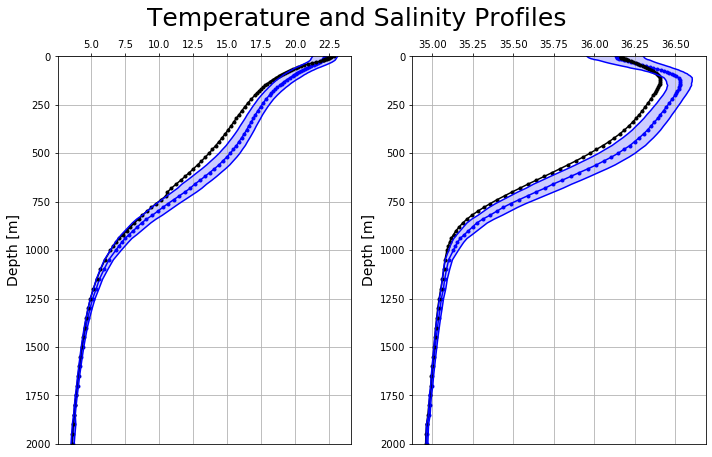

In [15]:
fig, axs = plt.subplots(1,2, figsize=(10, 6))
axs = axs.ravel()
title = 'Temperature and Salinity Profiles'
plt.suptitle(title,size = 25,y=1.05)
axs[0].plot(mean_temp_mod,vert_standart,'b.-', label='temp model')
axs[0].plot(mean_temp_en4,vert_standart,'k.-', label='temp en4')
axs[0].set_ylabel('Depth [m]', size=14)
axs[0].set_ylim(2000, 0)
axs[0].grid(True, which='both')
axs[0].xaxis.tick_top()
axs[0].xaxis.set_label_position('top') 
axs[0].plot(temp_percent10,vert_standart,'b-', label='percent10')
axs[0].plot(temp_percent90,vert_standart,'b-', label='percent90')
axs[0].fill_betweenx(vert_standart, temp_percent10, x2=temp_percent90, alpha=0.2, facecolor='b')

axs[1].plot(mean_salt_mod,vert_standart,'b.-', label='salt model')
axs[1].plot(mean_salt_en4,vert_standart,'k.-', label='salt en4')
axs[1].set_ylabel('Depth [m]', size=14)
axs[1].set_ylim(2000, 0)
axs[1].grid(True, which='both')
axs[1].xaxis.tick_top()
axs[1].xaxis.set_label_position('top') 
axs[1].plot(salt_percent10,vert_standart,'b-', label='percent10')
axs[1].plot(salt_percent90,vert_standart,'b-', label='percent90')
axs[1].fill_betweenx(vert_standart, salt_percent10, x2=salt_percent90, alpha=0.2, facecolor='b')


fig.tight_layout()
